In [1]:
from general_func import *
from load_data import *

color_map = {
"lambda0":"#e377c2",
"lambda1":"#7f7f7f",
"mu0":"#bcbd22",
"mu1":"#1f77b4",
"q01":"#17becf",
"q10":"#ff7f0e",
    
'net rate Anaerobe (Recent)':"#AB47BC", 
'net rate Aerobe (Recent)':"#FFEB3B",
'net rate Anaerobe (Past)':"#4A148C", 
'net rate Aerobe (Past)':"#E65100",
    
    'net rate Anaerobe':"#AB47BC", 
'net rate Aerobe':"#FFEB3B",
}


rename_map = {
"lambda0.1":"Speciation Anaerobe (Recent)",
"lambda1.1":"Speciation Aerobe (Recent)",
"mu0.1":"Extinction Anaerobe (Recent)",
"mu1.1":"Extinction Aerobe (Recent)",
"q01.1":"Anaerobe to Aerobe (Recent)",
"q10.1":"Aerobe to Anaerobe (Recent)",
"lambda0.2":"Speciation Anaerobe (Past)",
"lambda1.2":"Speciation Aerobe (Past)",
"mu0.2":"Extinction Anaerobe (Past)",
"mu1.2":"Extinction Aerobe (Past)",
"q01.2":"Anaerobe to Aerobe (Past)",
"q10.2":"Aerobe to Anaerobe (Past)",
}

os.chdir('/mnt/ivy/thliao/project/ML_oxygen')

8945
8943
(9328, 10054)
Counter({'aerobic': 3767, 'anaerobic': 1714, 'obligate aerobic': 1627, 'facultative': 953, 'microaerophilic': 726, 'obligate anaerobic': 156})


# load model and reference data

In [ ]:
reduced_data = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/keggbin_reduced.tsv',sep='\t',index_col=0)

top40 = open('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/top40.txt').read().strip().split('\n')
used_data = X.loc[:,top40]

LR_model = LR_m_ll(used_data, y_bin,)

In [4]:
model_name = './training_sets/gbdt_20240709_top40.xgb'
if not exists(model_name):
    gbdt_model = GBDT_m(used_data, y_bin,)
    gbdt_model.save_model(model_name)
else:
    gbdt_model = xgb.Booster()
    gbdt_model.load_model(model_name)

In [5]:
import shap

explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(used_data)

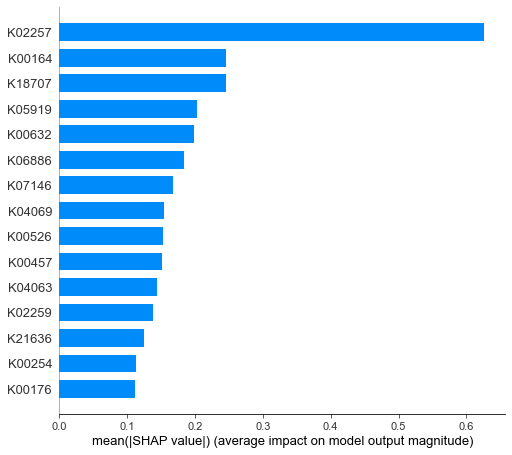

In [9]:
shap.summary_plot(shap_values, used_data,plot_type='bar',max_display=15)

In [10]:
id2corr_ids = {row.split('\t')[0]:row.split('\t')[-1] for row in open('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/15200_gids2IDmapping.txt').read().strip().split('\n')}

# prediction

## tip nodes of WoL

In [ ]:
from ete3 import Tree
ref_tree = Tree("/mnt/home-backup/thliao/wol_db/data/trees/astral/branch_length/cons/astral.cons.nid.nwk",1)
n = [_ for _ in ref_tree.traverse() if _.name == 'N7'][0]
assert len(n.get_leaf_names()) == 8452

anno_df = pd.read_csv("/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL_top50_bin.tab",sep='\t',index_col=0)
pred_results = anno_df.copy()
pred_results.loc[:,'gbdt prob'] = gbdt_model.predict(xgb.DMatrix(anno_df.reindex(columns=top50)))
pred_results.loc[:,'LR'] = LR_model.predict(anno_df.reindex(columns=top50))
pred_results.loc[:,'LR prob'] = LR_model.predict_proba(anno_df.reindex(columns=top50))[:,LR_model.classes_==1].reshape(-1)

sub_df = pred_results.reindex(columns=[_ for _ in pred_results.columns if not _.startswith('K')])
sub_df.loc[:,'predicted phenotype'] = ['aerobe' if _==1 else 'anaerobe' for _ in sub_df['LR']]
sub_df.loc[n.get_leaf_names(),:].to_excel('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/bacteria_top50_predictions.xlsx')
#sub_df.loc[[_ for _ in sub_df.index if _.startswith('GCA')],:]

anno_df = pd.read_csv("/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL_top50_bin.tab",sep='\t',index_col=0)
#anno_df.loc[n.get_leaf_names(),:].to_excel('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/bacteria_top50.xlsx')

In [91]:
from api_tools import *
c = {id2corr_ids[k]:'Anaerobe' if v==0 else 'Aerobe' for k,v in pred_results['LR'].to_dict().items()}
text = to_color_strip(c,{"Aerobe":"#FFC75F",
            "Anaerobe":"#D65DB1"},other_params={'margin':"50","strip_width":"50"},
                      dataset_name="LR prediction")
with open('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/15200_LR_colorstrip.txt','w') as f1:
    f1.write(text)
    
c = {id2corr_ids[k]:'Anaerobe' if v<=0.5 else 'Aerobe' for k,v in pred_results['gbdt prob'].to_dict().items()}
text = to_color_strip(c,{"Aerobe":"#FFC75F",
                         "Anaerobe":"#D65DB1"},other_params={'margin':"50","strip_width":"50"},
                      dataset_name="GBDT prediction")
with open('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/15200_GBDT_colorstrip.txt','w') as f1:
    f1.write(text)

In [31]:
c = {id2corr_ids[k]:'A' if v== else 'N' for k,v in pred_results['LR'].to_dict().items()}

with open('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/pruned_trees/gid2state.txt','w') as f1:
    for k,v in c.items():
        f1.write(f"{k}\t{v}\n")

### compare wol data in gtdb

In [343]:
ref_tree = Tree("/mnt/home-backup/thliao/wol_db/data/trees/astral/branch_length/cons/astral.cons.nid.nwk",1)
n = [_ for _ in ref_tree.traverse() if _.name == 'N7'][0]
short_gids = [_.replace('G','') for _ in n.get_leaf_names()]
anno_df = pd.read_csv("/mnt/ivy/thliao/project/ML_oxygen/testing_sets/GTDBv214_top50_bin.tab",sep='\t',index_col=0)

In [344]:
short_gids_gtdb = set([_.split('_')[-1].split('.')[0] for _ in anno_df.index])
len(set(short_gids).intersection(short_gids_gtdb))

4995

In [345]:
len(set(short_gids).difference(short_gids_gtdb))

3457

In [346]:
subtax = tax_df.loc[['G'+_ for _ in set(short_gids).difference(short_gids_gtdb)],:]
subtax.sort_values(list(subtax.columns))

In [348]:
metadata = pd.read_csv('/mnt/home-db/pub/gtdb/release214/metadata/bac120_metadata_r214.tsv',sep='\t',index_col=0)

In [357]:
short_gids_gtdb_full = set([_.split('_')[-1].split('.')[0] for _ in metadata.index])
missing_wol = set(short_gids).intersection(short_gids_gtdb_full).difference(short_gids_gtdb)

In [375]:
missingwol_gtdb_ids = [_ for _ in metadata.index if _.split('_')[-1].split('.')[0] in missing_wol]
subm = metadata.loc[missingwol_gtdb_ids,'gtdb_genome_representative']
mapGIDS = {k.split('_')[-1].split('.')[0]:v for k,v in subm.to_dict().items()}

In [380]:
shared_gids = set(short_gids).intersection(short_gids_gtdb)
final_gtdbids = []
for i in anno_df.index:
    if i.split('_')[-1].split('.')[0] in shared_gids:
        final_gtdbids.append(i)
for i in n.get_leaf_names():
    i = i.replace('G','')
    if i in mapGIDS:
        final_gtdbids.append(mapGIDS[i])
print(len(set(final_gtdbids)))
## these are genomes in GTDB v214 and  in WOL

#used these to subset the GTDB dataset and see the differences

In [382]:
sharedWOLGTDB_gids = list(final_gtdbids)

## tip nodes of GTDB v214

In [7]:
from ete3 import Tree

ref_tree = Tree(open('/mnt/home-db/pub/gtdb/release214/bac120_r214.tree').read().strip().replace('d__Bacteria',''),3,quoted_node_names=True)



anno_df = pd.read_csv("/mnt/ivy/thliao/project/ML_oxygen/testing_sets/GTDBv214_top40_bin.tab",sep='\t',index_col=0)
pred_results = anno_df.copy()
pred_results.loc[:,'gbdt prob'] = gbdt_model.predict(xgb.DMatrix(anno_df.reindex(columns=top40)))
pred_results.loc[:,'LR'] = LR_model.predict(anno_df.reindex(columns=top40))
pred_results.loc[:,'LR prob'] = LR_model.predict_proba(anno_df.reindex(columns=top40))[:,LR_model.classes_==1].reshape(-1)


NameError: name 'gbdt_model' is not defined

In [ ]:
pred_results.to_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/LR_predicted.tab',sep='\t',index=1)

In [116]:
print(len(ref_tree.get_leaf_names()),anno_df.shape)

80789 (80789, 40)


In [117]:
set(ref_tree.get_leaf_names()).difference(set(anno_df.index))

set()

In [128]:
sub_df = pred_results.reindex(columns=[_ for _ in pred_results.columns if not _.startswith('K')])
sub_df.loc[:,'predicted phenotype'] = ['Aerobe' if _==1 else 'Anaerobe' for _ in sub_df['LR']]
sub_df.groupby('predicted phenotype').size()

In [ ]:
sub_df.loc[[_ for _ in ref_tree.get_leaf_names() if _ in sub_df.index],:].to_excel('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/GTDB_r214/bacteria_top40_predictions.xlsx')


In [120]:
pred_results.to_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/LR_predicted.tab',sep='\t',index=1)

In [129]:
from api_tools import *
c = {k:v for k,v in sub_df['predicted phenotype'].to_dict().items()}
text = to_color_strip(c,{"Aerobe":"#FFC75F",
            "Anaerobe":"#D65DB1"},other_params={'margin':"50","strip_width":"50"},
                      dataset_name="LR prediction")
with open('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/LR_colorstrip.txt','w') as f1:
    f1.write(text)
    

In [63]:
subgtdbtax_df = gtdbtax_df.loc[~gtdbtax_df['pheno'].isna(),:]
aa = subgtdbtax_df.groupby(['p','pheno']).size()#.sort_values()

In [79]:
b = subgtdbtax_df.groupby('p').size()

In [81]:
plt1000 = b.index[b>=1000]
plt1000

Index(['Acidobacteriota', 'Actinomycetota', 'Bacillota', 'Bacillota_A',
       'Bacteroidota', 'Chloroflexota', 'Cyanobacteriota', 'Desulfobacterota',
       'Patescibacteria', 'Planctomycetota', 'Pseudomonadota',
       'Verrucomicrobiota'],
      dtype='object', name='p')

In [83]:
plt1000_df = subgtdbtax_df.loc[subgtdbtax_df.p.isin(plt1000),:]

In [84]:
p2ratio = {}
for p,_df in plt1000_df.groupby('p'):
    c = _df.groupby('pheno').size()
    p2ratio[p] = round(c/c.sum()*100,2)

# Bisse results parsegtdbtax_df

## Wol

In [139]:
dfs = []
indir = '/mnt/storage3/thliao/project/ML_oxygen/testing_sets/WoL/Bisse_output/sampling'
for i in glob(indir+'/full*Y.bissetb.tsv'):
    point = int(i.split('/')[-1].split('Y.')[0].replace('full',''))
    rows = open(i).read().strip().split('\n')
    d = pd.DataFrame([_.split('\t') for _ in rows[1:]])
    d.index = d[0]
    d.pop(0)
    d = d.T
    d.index = [point]
    dfs.append(d)
df = pd.concat(dfs,axis=0)
df = df.sort_index()

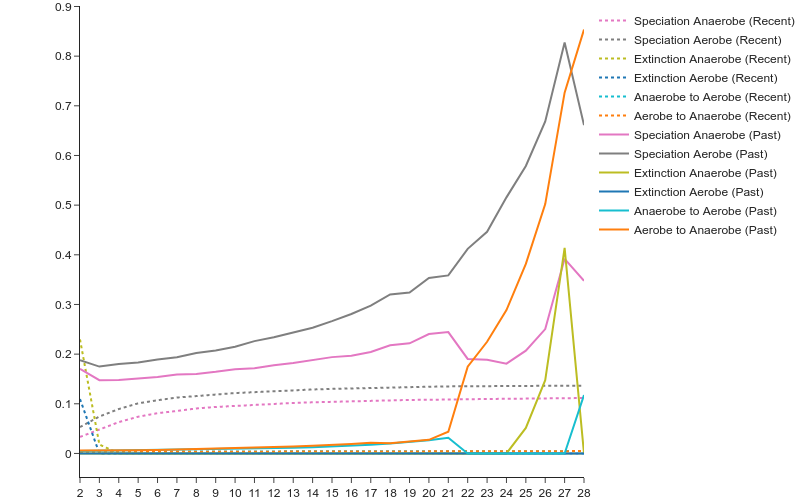

In [172]:
from IPython.display import Image,display
fig = go.Figure()
for col in df.columns[:-1]:
    if '.2' in col:
        #s = 'circle'
        ld = "solid"
    else:
        ld = "dot"
    name = rename_map[col]
    c = color_map[col.split('.')[0]]
    fig.add_scatter(x=list(df.index),y=list(df[col]),mode='lines',name=name,
                    line=dict(dash=ld, width=2,),marker_color=c)
fig.update_layout(template='simple_white',height=500,width=800,margin_t=0,margin_b=0,xaxis_dtick=1)
display(Image(fig.to_image()))

## gtdb

In [60]:
gtdbdfs = []
indir = '/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/sequential_dating'
for i in glob(indir+'/full*Y.bissetb.tsv'):
    point = int(i.split('/')[-1].split('Y.')[0].replace('full',''))
    rows = open(i).read().strip().split('\n')
    d = pd.DataFrame([_.split('\t') for _ in rows[1:]])
    d.index = d[0]
    d.pop(0)
    d = d.T
    d.index = [point]
    gtdbdfs.append(d)
gtdbdf = pd.concat(gtdbdfs,axis=0)
gtdbdf = gtdbdf.sort_index()
gtdbdf = gtdbdf.astype(float)

In [34]:
gtdbdf.loc[:,'net rate Anaerobe (Recent)'] = gtdbdf['lambda0.1'] - gtdbdf['mu0.1']
gtdbdf.loc[:,'net rate Aerobe (Recent)'] = gtdbdf['lambda1.1'] - gtdbdf['mu1.1']

gtdbdf.loc[:,'net rate Anaerobe (Past)'] = gtdbdf['lambda0.2'] - gtdbdf['mu0.2']
gtdbdf.loc[:,'net rate Aerobe (Past)'] = gtdbdf['lambda1.2'] - gtdbdf['mu1.2']

In [58]:
c = ['lambda0', 'lambda1', 'mu0', 'mu1', 'q01', 'q10',
       'net rate Anaerobe', 'net rate Aerobe',]
ngtdbdf = pd.DataFrame(columns=c)
for i1,i2 in zip(gtdbdf.index,gtdbdf.index[1:]):
    ngtdbdf.loc[f'{i1}-{i2}','lambda0'] = (gtdbdf.loc[i1,'lambda0.2'] + gtdbdf.loc[i2,'lambda0.2'])/2
    ngtdbdf.loc[f'{i1}-{i2}','lambda1'] = (gtdbdf.loc[i1,'lambda1.2'] + gtdbdf.loc[i2,'lambda1.2'])/2
    ngtdbdf.loc[f'{i1}-{i2}','mu0'] = (gtdbdf.loc[i1,'mu0.2'] + gtdbdf.loc[i2,'mu0.2'])/2
    ngtdbdf.loc[f'{i1}-{i2}','mu1'] = (gtdbdf.loc[i1,'mu1.2'] + gtdbdf.loc[i2,'mu1.2'])/2
    ngtdbdf.loc[f'{i1}-{i2}','q01'] = (gtdbdf.loc[i1,'q01.2'] + gtdbdf.loc[i2,'q01.2'])/2
    ngtdbdf.loc[f'{i1}-{i2}','q10'] = (gtdbdf.loc[i1,'q10.2'] + gtdbdf.loc[i2,'q10.2'])/2
    
    ngtdbdf.loc[f'{i1}-{i2}','net rate Anaerobe'] = (gtdbdf.loc[i1,'net rate Anaerobe (Past)'] + gtdbdf.loc[i2,'net rate Anaerobe (Past)'])/2
    ngtdbdf.loc[f'{i1}-{i2}','net rate Aerobe'] = (gtdbdf.loc[i1,'net rate Aerobe (Past)'] + gtdbdf.loc[i2,'net rate Aerobe (Past)'])/2
    ngtdbdf.loc[f'{i1}-{i2}','loc'] = (i1+i2)/2
ngtdbdf

,lambda0,lambda1,mu0,mu1,q01,q10,net rate Anaerobe,net rate Aerobe,loc
1-2,0.163037,0.177255,0.0,0.0,0.003143,0.003842,0.163037,0.177255,1.5
2-3,0.143905,0.15471,0.000001,0.000008,0.003042,0.003823,0.143904,0.154703,2.5
3-4,0.13985,0.148335,0.000001,0.000008,0.002973,0.00382,0.139849,0.148327,3.5
4-5,0.142227,0.151501,0.0,0.000001,0.00298,0.003835,0.142227,0.151501,4.5
5-6,0.14418,0.154225,0.000005,0.000001,0.003017,0.003961,0.144175,0.154224,5.5
6-7,0.145913,0.156905,0.000008,0.000001,0.003127,0.004116,0.145905,0.156905,6.5
7-8,0.147637,0.159776,0.000004,0.0,0.003261,0.004279,0.147633,0.159776,7.5
8-9,0.149315,0.162512,0.0,0.00001,0.003386,0.004496,0.149315,0.162503,8.5
9-10,0.150966,0.165834,0.000001,0.000011,0.003504,0.004716,0.150964,0.165823,9.5
10-11,0.152846,0.169162,0.000003,0.000001,0.003625,0.004955,0.152843,0.169161,10.5


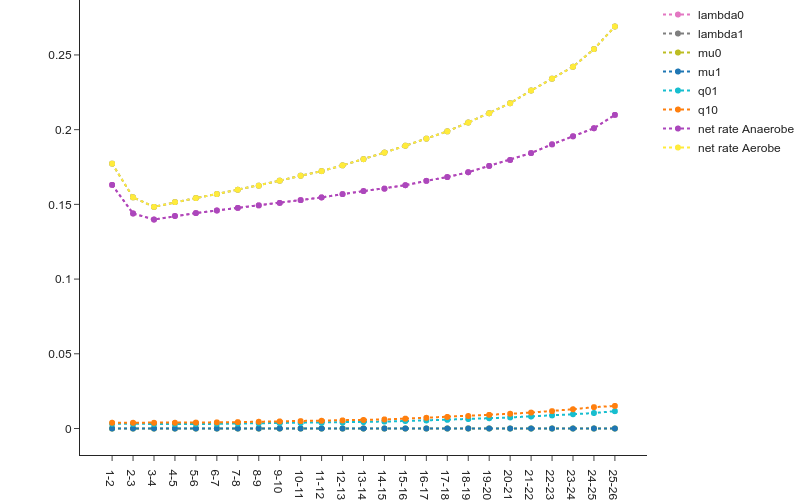

In [59]:
from IPython.display import Image,display
fig = go.Figure()
for col in ngtdbdf.columns[:-1]:
    if '.2' in col:
        #s = 'circle'
        ld = "solid"
    else:
        ld = "dot"
    name = rename_map.get(col,col)
    c = color_map[col.split('.')[0]]
    fig.add_scatter(x=list(ngtdbdf.loc[:,'loc']),y=list(ngtdbdf[col]),mode='markers+lines',name=name,
                    line=dict(dash=ld, width=2,),marker_color=c)
fig.update_layout(template='simple_white',height=500,width=800,margin_t=0,margin_b=0,xaxis_dtick=1,
                 xaxis_ticktext=list(ngtdbdf.index),
                 xaxis_tickvals=list(ngtdbdf['loc']))
display(Image(fig.to_image()))

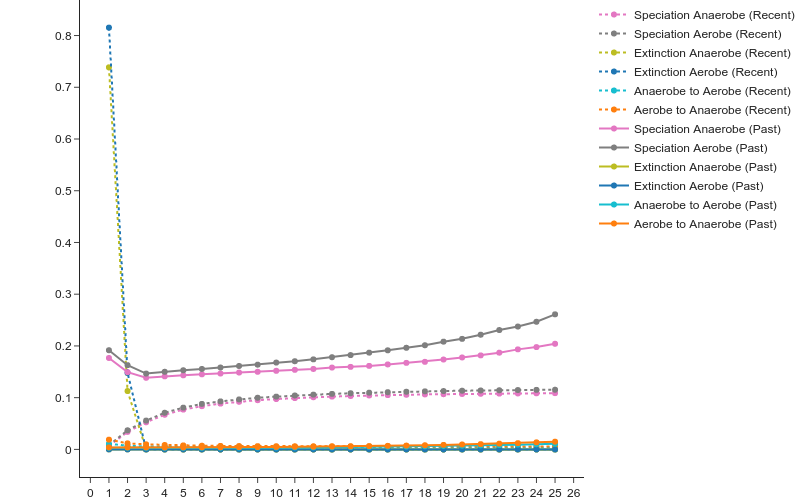

In [14]:
from IPython.display import Image,display
fig = go.Figure()
for col in [ #'q01.1', 'q10.1',
       #'q01.2', 'q10.2', 
       'net rate Anaerobe (Recent)', 'net rate Aerobe (Recent)',
       'net rate Anaerobe (Past)', 'net rate Aerobe (Past)']:
    if '.2' in col:
        #s = 'circle'
        ld = "solid"
    else:
        ld = "dot"
    name = rename_map.get(col,col)
    c = color_map[col.split('.')[0]]
    fig.add_scatter(x=list(gtdbdf.index),y=list(gtdbdf[col]),mode='markers+lines',name=name,
                    line=dict(dash=ld, width=2,),marker_color=c)
fig.update_layout(template='simple_white',height=500,width=800,margin_t=0,margin_b=0,xaxis_dtick=1)
display(Image(fig.to_image()))

# NA

## tree based clustering

In [ ]:
from ete3 import Tree
ref_tree = Tree("/mnt/home-backup/thliao/wol_db/data/trees/astral/branch_length/cons/astral.cons.nid.nwk",1)
n = [_ for _ in ref_tree.traverse() if _.name == 'N7'][0]
inter2ratio = {}
for inter in n.traverse():
    if inter.is_leaf():
        continue
    else:
        an_leaves = [_ for _ in inter.get_leaf_names() if tip2phento[_]=='anaerobe']
        aero_leaves = [_ for _ in inter.get_leaf_names() if tip2phento[_]=='aerobe']
        inter2ratio[inter.name] = (len(aero_leaves)/len(an_leaves+aero_leaves),len(an_leaves+aero_leaves))
inter2ratio

In [ ]:
factor = 0.2
stre = n.copy()
_n = 0
tip2c = {}
for n in stre.traverse():
    this_gids = n.get_leaf_names()
    if all([_ in tip2c for _ in this_gids]):
        continue
    if len(this_gids)==1:
        tip2c[this_gids[0]] = f'cluster{_n}'
        _n+=1 
        continue       
    an_leaves = [_ for _ in inter.get_leaf_names() if tip2phento[_]=='anaerobe']
    aero_leaves = [_ for _ in inter.get_leaf_names() if tip2phento[_]=='aerobe']
    aero_ratio = (len(aero_leaves)/len(an_leaves+aero_leaves),len(an_leaves+aero_leaves))
    if aero_ratio > 90:
        # g = random.choice(this_gids)
        for _ in this_gids:
            tip2c[_] = f'cluster{_n}'
        _n += 1
#print(thres,len(left_gids),len(set(tip2c.values())))
stats_dict[thres] = len(set(tip2c.values()))
group_dict[thres] = tip2c

## internal nodes of verruco

In [51]:
verr_ances = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/Verrucomicrobiota/reconstructed_bin.tab',sep='\t',index_col=0).reindex(columns=top50).fillna(0)
verr_ances_predicted = verr_ances.copy()
verr_ances_predicted.loc[:,'gbdt'] = gbdt_model.predict(xgb.DMatrix(verr_ances))
verr_ances_predicted.loc[:,'LR'] = LR_model.predict(verr_ances)
verr_ances_predicted.loc[:,'LR prob'] = LR_model.predict_proba(verr_ances)[:,LR_model.classes_==1].reshape(-1)

In [57]:
from api_tools import pie_chart
cat2info = {"A":"#FFC75F",
            "N":"#D65DB1"}
n2cat2prob = {n: {'A':prob,"N":1-prob}
                for n,prob in verr_ances_predicted['LR prob'].to_dict().items()}
     
text = pie_chart(n2cat2prob, cat2info,pos=0.5 )
with open('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/Verrucomicrobiota/reconstructed_itol_piechart.txt','w') as f1:
    f1.write(text)

In [78]:
r_df = parse_r('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/pruned_trees/Verrucomicrobiota_MK/complex_habitat_prob.itol.txt',fea='A')
verr_ances_predicted.loc[:,'recon pheno prob'] = r_df['Verrucomicrobiota']
verr_ances_predicted.loc[:,'dist to root'] = [name2dist.get(n,0) for n in verr_ances_predicted.index]
verr_ances_predicted.loc[:,'name'] = verr_ances_predicted.index

In [73]:
from ete3 import Tree
intree = f"/mnt/ivy/thliao/project/ML_oxygen/testing_sets/pruned_trees/Verrucomicrobiota.newick"
tre = Tree(intree,3)
name2dist = {n.name:n.get_distance(tre) for n in tre.traverse()}

Tree node 'I0_S1' (0x7f760b9c57d)

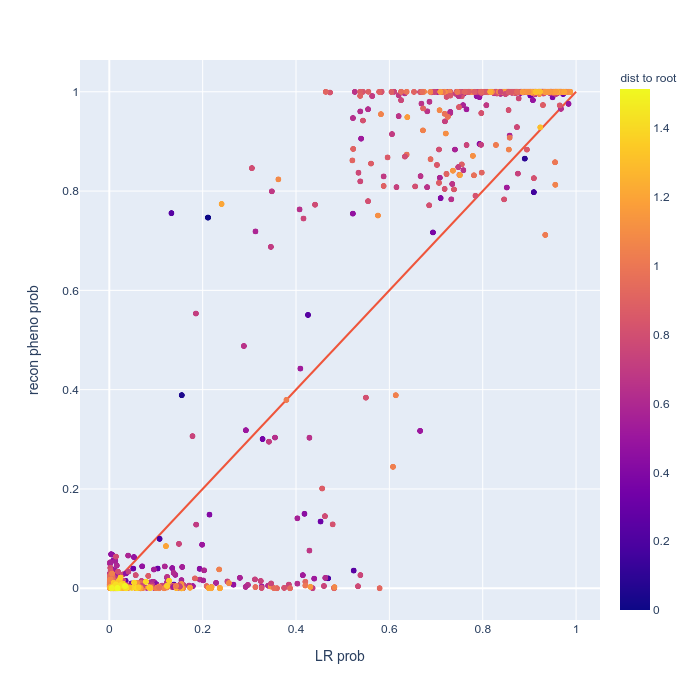

In [93]:
import plotly.express as px
fig = px.scatter(verr_ances_predicted,
                 x='LR prob',y='recon pheno prob',color='dist to root',
                 text='name')
fig.update_traces(mode='markers')
fig.add_scatter(x=[0,1],y=[0,1],mode='lines',showlegend=False)

fig.layout.height = 700
fig.layout.width = 700
display(Image(fig.to_image()))

## internal nodes of GTDB

### ACE-first

In [19]:
dfs = []
for f in tqdm(glob('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/ACE/*.anc')):
    d = pd.read_csv(f,sep='\t',index_col=0)
    d.index = ['OROOT'] + list(d.index)[1:]
    name = f.split('/')[-1].split('.')[0]
    d.loc[:,name] = [r[1] for _,r in d.iterrows()]
    dfs.append(d.loc[:,[name]])
total_df = pd.concat(dfs,axis=1)

100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


In [21]:
total_df = total_df.reindex(columns=top40).fillna(0)
GTDB_ances_predicted = total_df.copy()
#GTDB_ances_predicted.loc[:,'gbdt'] = gbdt_model.predict(xgb.DMatrix(total_df))
GTDB_ances_predicted.loc[:,'LR'] = LR_model.predict(total_df)
GTDB_ances_predicted.loc[:,'LR prob'] = LR_model.predict_proba(total_df)[:,LR_model.classes_==1].reshape(-1)

In [136]:
tre = Tree("/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/sequential_dating/root45_dated_20240328.nwk",1)
n2dist = {}
for a in tqdm(tre.traverse()):
    n2dist[a.name] = tre.get_distance(a)

161573it [00:08, 17968.57it/s]


In [23]:
pred_results = pd.read_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/LR_predicted.tab',sep='\t',index_col=0)
d1 = pred_results[['LR prob']]
d1.columns = ['A']
d1.loc[:,'N'] = 1-d1['A']
d1.loc[:,'dist'] = [n2dist.get(_,0) for _ in d1.index]
d2 = GTDB_ances_predicted[['LR prob']]
d2.columns = ['A']
d2.loc[:,'N'] = 1-d2['A']
d2.loc[:,'dist'] = [n2dist.get(_,0) for _ in d2.index]
merged = pd.concat([d1,d2],axis=0)
merged

,A,N,dist
GB_GCA_012799545.1,0.011203,0.988797,44.5232
RS_GCF_000378205.1,0.007702,0.992298,44.5232
GB_GCA_011046055.1,0.014535,0.985465,44.5232
GB_GCA_902797395.1,0.006884,0.993116,44.5232
GB_GCA_003456855.1,0.013534,0.986466,44.5232
...,...,...,...
INO67,0.003347,0.996653,44.5232
INO103,0.003347,0.996653,44.5232
INO66,0.003347,0.996653,44.5232
INO102,0.003347,0.996653,44.5232


In [24]:
merged.to_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/ACE/Allnodes_predicted.tsv',sep='\t',index=1)


In [9]:
merged = pd.read_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/ACE/Allnodes_predicted.tsv',sep='\t',index_col=0)
#merged

In [14]:
sub = merged.loc[(merged.A>=merged.N),:]
sub['dist'].max() - sub.loc[[_ for _ in sub.index if _.startswith("INO")],:].sort_values('dist').iloc[0,2]

27.392329999999998

In [15]:
sub.loc[[_ for _ in sub.index if _.startswith("INO")],:].sort_values('dist')

,A,N,dist
INO96,0.503099,0.496901,17.130930
INO1149,0.545430,0.454570,18.425588
INO810,0.617517,0.382483,19.298249
INO825,0.738853,0.261147,19.781378
INO141,0.648357,0.351643,19.827300
...,...,...,...
INO80421,0.987934,0.012066,44.522931
INO80784,0.950523,0.049477,44.522940
INO80420,0.987934,0.012066,44.522971
INO80787,0.950523,0.049477,44.523091


100%|██████████| 21/21 [00:00<00:00, 66.05it/s]


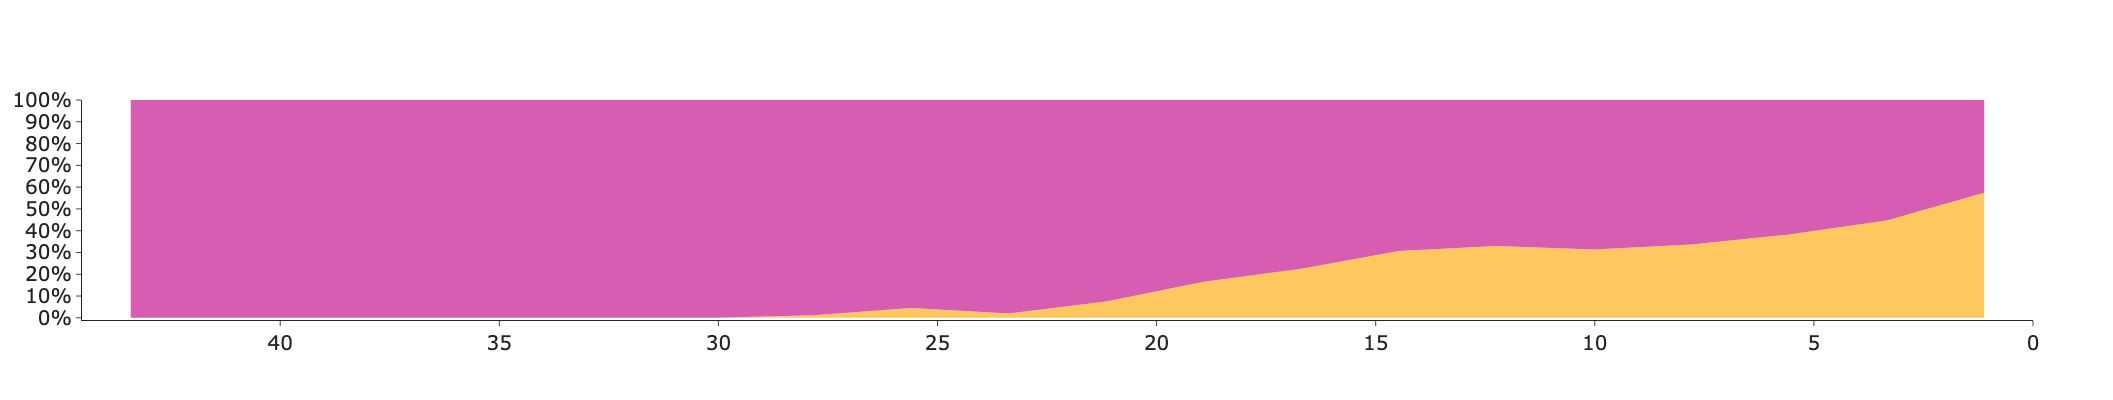

In [138]:
import plotly.graph_objects as go

col = 'dist'
hist_d = np.histogram(merged[col], bins=20, range = (0,max(merged[col])) )
xs = []
ys1 = []
ys2 = []
ys = []
left = 0
for right in tqdm(hist_d[1]):
    #print(left,right)
    sdf = merged.loc[(merged[col]>=left) & (merged[col]<right),:]
    sdf = sdf.loc[[_ for _ in sdf.index if _.startswith('INO')],:]
    if sdf.shape[0]==0:continue
    num_anaerobe = len(sdf.index[sdf['A']<0.5])
    num_aerobe = sdf.shape[0]-num_anaerobe
    ys2.append(num_aerobe/sdf.shape[0])
    ys1.append(num_anaerobe/sdf.shape[0])
    ys.append(sdf.shape[0]/(merged.shape[0]-d1.shape[0]))
    xs.append(max(merged[col])-(left+right)/2)
    left = right

fig = go.Figure()
fig.add_scatter(x=xs,y=ys2,mode='lines',opacity=0.7,fillcolor='#FFC75F', 
                marker=dict(size=4),
                name='Aerobe',fill='tozeroy',stackgroup='one',line=dict(width=0),showlegend=False)
fig.add_scatter(x=xs,y=ys1,mode='lines',opacity=0.7,fillcolor='#D65DB1',
                name='Anaerobe',fill='tonexty',stackgroup='one',line=dict(width=0),showlegend=False)
# fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
fig.update_layout(height=400,width=600,xaxis_range=[max(merged[col]),0],yaxis_zeroline=False,yaxis_range=[-0.01,1],
                  yaxis_dtick=0.1,yaxis_tickformat=',.0%',
                  font_size=20,
                 template='simple_white')
fig.show()

In [139]:
fig.write_image('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/root45_20240328_changed.pdf')

In [ ]:
submerged = merged.loc[[_ for _ in merged.index if _.startswith('INO')],:]
submerged.loc[:,'time'] = 44.52320 - submerged['dist']
submerged.loc[:,'state'] = ['Aerobe' if row['A']>row['N'] else 'Anaerobe' for r,row in submerged.iterrows()]
submerged.loc[submerged['state'] == 'Aerobe',:].sort_values('time')
#merged.loc[:,'44.52320 - merged.loc[[_ for _ in merged.index if _.startswith('INO')],'dist']

In [ ]:
tmpmerged = submerged.loc[submerged['state'] == 'Aerobe',:].copy()
tmpmerged = tmpmerged.loc[(tmpmerged['time']>15)&(tmpmerged['time']<=30),:]
tmpmerged.shape

In [ ]:
merged.loc[:,'state'] = ['Aerobe' if row['A']>row['N'] else 'Anaerobe' for r,row in merged.iterrows()]

In [252]:
tmpmerged2 = submerged.loc[submerged['state'] == 'Anaerobe',:].copy()
tmpmerged2 = tmpmerged2.loc[tmpmerged2['time']<15,:]

for inode in tmpmerged2.index:
    if merged.loc[n2node[inode].up.name,'A'] >=0.8 and merged.loc[inode,'N'] >0.7:
        if len(n2node[inode].get_leaf_names())>=100:
            print(inode,len(gtdbtax_df.loc[ n2node[inode].get_leaf_names(),'f'].unique()))
        
    INO8990
gtdbtax_df.loc[ n2node['INO25910'].get_leaf_names(),:]

submerged.loc['INO25910','state']
merged.loc['INO25910',:]
merged.loc[n2node['INO25910'].get_leaf_names(),:].groupby('state').count()
gtdbtax_df.loc[gtdbtax_df.f=='Methylomonadaceae',:].shape

,A,N,dist,time,state
INO2,0.045968,0.954032,0.00000,44.52320,Anaerobe
INO6,0.043980,0.956020,1.01986,43.50334,Anaerobe
INO13,0.038774,0.961226,2.27495,42.24825,Anaerobe
INO24,0.034671,0.965329,3.29012,41.23308,Anaerobe
INO41,0.031219,0.968781,4.38907,40.13413,Anaerobe
...,...,...,...,...,...
INO67,0.003347,0.996653,44.52320,0.00000,Anaerobe
INO103,0.003347,0.996653,44.52320,0.00000,Anaerobe
INO66,0.003347,0.996653,44.52320,0.00000,Anaerobe
INO102,0.003347,0.996653,44.52320,0.00000,Anaerobe


In [ ]:
from api_tools import *
tipid2pheno = tmpmerged.loc[:,['A','N']].to_dict(orient='index')
text = pie_chart(tipid2pheno,
                 {"A":"#FFC75F",
                  "N":"#D65DB1"},dataset_name='predicted prob')
with open('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/LRpredicted_piechart.txt','w') as f1:
    f1.write(text)
    
    

In [152]:
import plotly
colors = plotly.colors.qualitative.Dark24
tax = sorted(gtdbtax_df.groupby('p').size().sort_values()[-20:].index)
t2c = {'Acidobacteriota': '#2E91E5',
 'Actinomycetota': '#E15F99',
 'Bacillota': '#1CA71C',
 'Bacillota_A': '#004223',
 'Bacillota_C': '#00e7b5',
 'Bacteroidota': '#222A2A',
 'Campylobacterota': '#B68100',
 'Chloroflexota': '#750D86',
 'Cyanobacteriota': '#EB663B',
 'Desulfobacterota': '#511CFB',
 'Halobacteriota': '#00A08B',
 'Myxococcota': '#FB00D1',
 'Nanoarchaeota': '#FC0080',
 'Patescibacteria': '#B2828D',
 'Planctomycetota': '#6C7C32',
 'Pseudomonadota': '#778AAE',
 'Spirochaetota': '#862A16',
 'Thermoplasmatota': '#A777F1',
 'Thermoproteota': '#620042',
 'Verrucomicrobiota': '#1616A7'}

In [152]:
gid2tax = gtdbtax_df.loc[gtdbtax_df['p'].isin(tax),'p'].to_dict()

In [160]:
n2node = {n.name:n for n in tre.traverse()}

In [ ]:
tmpmerged2 = submerged.loc[(submerged['time']<=15),:]
collapsed_tips = []
collect_same_p = []
for i in tqdm(tmpmerged2.index):
    subtax = gtdbtax_df.loc[n2node[i].get_leaf_names(),'p'].unique()
    if len(subtax)==1:
        collect_same_p.append(i)
        if subtax[0] in tax:
            gid2tax[i] = subtax[0]
        collapsed_tips.extend(n2node[i].get_leaf_names())

collapsed_tips = list(set(collapsed_tips)) 
collect_same_p = set(collect_same_p)
tipid2pheno = pred_results['LR'].to_dict()
tipid2pheno = {k:'Aerobe' if v ==1 else 'Anaerobe' for k,v in tipid2pheno.items() if k not in collapsed_tips}
for k,row in submerged.iterrows():
    if k in collect_same_p:
        tipid2pheno[k] = row['state']

In [ ]:
text = to_color_strip(gid2tax,t2c,other_params={'margin':"50","strip_width":"50"},
                      dataset_name="GTDB phylum")
with open('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214//Tax_colorstrip.txt','w') as f1:
    f1.write(text)
    
text = to_color_strip(tipid2pheno,{"Aerobe":"#FFC75F",
            "Anaerobe":"#D65DB1"},other_params={'margin':"50","strip_width":"50"},
                      dataset_name="LR prediction")
with open('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/LR_colorstrip.txt','w') as f1:
    f1.write(text)
    
    
content = '''COLLAPSE
DATA'''
with open('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214//collapsed.txt','w') as f1:
    f1.write(content+'\n'+'\n'.join(collect_same_p))

### prune GTDB with WOL

In [384]:
merged = pd.read_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/ACE/Allnodes_predicted.tsv',sep='\t',index_col=0)

In [386]:
tre = Tree("/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/sequential_dating/root45_dated.nwk",1)
tre.prune(sharedWOLGTDB_gids)
names = [_.name for _ in tre.traverse()]
names = ['OROOT'] + names[1:]
merged = merged.loc[names,:]

100%|██████████| 21/21 [00:00<00:00, 232.36it/s]


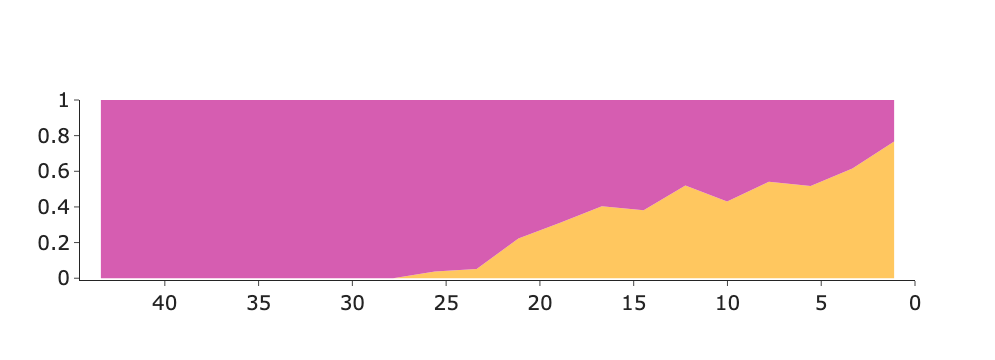

In [390]:
col = 'dist'
hist_d = np.histogram(merged[col], bins=20, range = (0,max(merged[col])) )
xs = []
ys1 = []
ys2 = []
ys = []
left = 0
for right in tqdm(hist_d[1]):
    #print(left,right)
    sdf = merged.loc[(merged[col]>=left) & (merged[col]<right),:]
    sdf = sdf.loc[[_ for _ in sdf.index if _.startswith('INO')],:]
    if sdf.shape[0]==0:continue
    num_anaerobe = len(sdf.index[sdf['A']<0.5])
    num_aerobe = sdf.shape[0]-num_anaerobe
    ys2.append(num_aerobe/sdf.shape[0])
    ys1.append(num_anaerobe/sdf.shape[0])
    ys.append(sdf.shape[0]/(merged.shape[0]-d1.shape[0]))
    xs.append(max(merged[col])-(left+right)/2)
    left = right
import plotly.graph_objects as go
fig = go.Figure()
fig.add_scatter(x=xs,y=ys2,mode='lines',opacity=0.7,fillcolor='#FFC75F', 
                marker=dict(size=4),
                name='Aerobe',fill='tozeroy',stackgroup='one',line=dict(width=0),showlegend=False)
fig.add_scatter(x=xs,y=ys1,mode='lines',opacity=0.7,fillcolor='#D65DB1',
                name='Anaerobe',fill='tonexty',stackgroup='one',line=dict(width=0),showlegend=False)
# fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
fig.update_layout(height=300,width=600,xaxis_range=[max(merged[col]),0],yaxis_zeroline=False,yaxis_range=[-0.01,1],
                  font_size=20,
                 template='simple_white')
fig.show()

### ACE direclty

In [318]:
merged = pd.read_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/ACE/Allnodes_predicted.tsv',sep='\t',index_col=0)

d = pd.read_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/sequential_dating/80787.apeace_ACE.tsv',sep='\t',index_col=0)
d.index = ['OROOT'] + list(d.index)[1:]
merged.loc[d.index,'A'] = d['1']
merged.loc[d.index,'N'] = d['0']

col = 'dist'
hist_d = np.histogram(merged[col], bins=20, range = (0,max(merged[col])) )
xs = []
ys1 = []
ys2 = []
ys = []
left = 0
for right in tqdm(hist_d[1]):
    #print(left,right)
    sdf = merged.loc[(merged[col]>=left) & (merged[col]<right),:]
    sdf = sdf.loc[[_ for _ in sdf.index if _.startswith('INO')],:]
    if sdf.shape[0]==0:continue
    num_anaerobe = len(sdf.index[sdf['A']<0.5])
    num_aerobe = sdf.shape[0]-num_anaerobe
    ys2.append(num_aerobe/sdf.shape[0])
    ys1.append(num_anaerobe/sdf.shape[0])
    ys.append(sdf.shape[0]/(merged.shape[0]-d1.shape[0]))
    xs.append(max(merged[col])-(left+right)/2)
    left = right
import plotly.graph_objects as go
fig = go.Figure()
fig.add_scatter(x=xs,y=ys2,mode='lines',opacity=0.7,fillcolor='#FFC75F', 
                marker=dict(size=4),
                name='Aerobe',fill='tozeroy',stackgroup='one',line=dict(width=0),showlegend=False)
fig.add_scatter(x=xs,y=ys1,mode='lines',opacity=0.7,fillcolor='#D65DB1',
                name='Anaerobe',fill='tonexty',stackgroup='one',line=dict(width=0),showlegend=False)
# fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
fig.update_layout(height=300,width=600,xaxis_range=[max(merged[col]),0],yaxis_zeroline=False,yaxis_range=[-0.01,1],
                  font_size=20,
                 template='simple_white')
fig.show()

# root45 example aerobic/anaerobic changes along time

In [50]:
from ete3 import Tree
from glob import glob
import pandas as pd

merged = pd.read_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/ACE/Allnodes_predicted.tsv',sep='\t',index_col=0)

d = pd.read_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/sequential_dating/80787.apeace_ACE.tsv',sep='\t',index_col=0)
d.index = ['OROOT'] + list(d.index)[1:]
merged.loc[d.index,'A'] = round(d['1'],2)
merged.loc[d.index,'N'] = round(d['0'],2)
merged.loc[:,'age'] = round(merged['dist'].max()-merged['dist'],2)

In [34]:
#root2n2dget_leaf_names
#reftre = Tree("/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/sequential_dating/root45_dated.nwk",1)
tpath = '/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/sequential_dating/root45_dated_20240328.nwk'
tre = Tree(tpath,3)
n2dist = {}
for n2 in tqdm(tre.traverse()):
    n2dist[n2.name] = tre.get_distance(n2)
root2n2dist['45'] = n2dist

161573it [00:08, 19711.81it/s]


In [38]:
cynon = tre.get_common_ancestor( list(gtdbtax_df.loc[gtdbtax_df.loc[:,'p']== 'Cyanobacteriota',:].index))

In [53]:
n2node = {}
for n in tre.traverse():
    n2node[n.name] = n

In [67]:
gtdbtax_df.loc[n2node['INO869'].children[1].get_leaf_names(),'o']

0
GB_GCA_903970355.1    Obscuribacterales
GB_GCA_003175915.1    Obscuribacterales
GB_GCA_013288645.1    Obscuribacterales
GB_GCA_018266255.1    Obscuribacterales
GB_GCA_003963305.1    Obscuribacterales
GB_GCA_003153555.1    Obscuribacterales
GB_GCA_003151275.1    Obscuribacterales
GB_GCA_903970295.1    Obscuribacterales
GB_GCA_012965515.1    Obscuribacterales
GB_GCA_019745505.1    Obscuribacterales
GB_GCA_003242885.1    Obscuribacterales
GB_GCA_020853845.1    Obscuribacterales
GB_GCA_013997645.1    Obscuribacterales
GB_GCA_013823055.1    Obscuribacterales
GB_GCA_020854255.1    Obscuribacterales
GB_GCA_014380105.1    Obscuribacterales
GB_GCA_016716405.1    Obscuribacterales
GB_GCA_020431945.1    Obscuribacterales
GB_GCA_020634035.1    Obscuribacterales
GB_GCA_016124935.1    Obscuribacterales
GB_GCA_019637435.1    Obscuribacterales
GB_GCA_021772095.1    Obscuribacterales
GB_GCA_019746975.1    Obscuribacterales
GB_GCA_021324135.1    Obscuribacterales
GB_GCA_016699165.1    Obscuribacterale

In [55]:
merged.loc[[_.name for _ in cynon.traverse() if _.name.startswith('INO')],:].sort_values('age')

,A,N,dist,age
INO79541,1.00,0.00,44.518319,0.00
INO79935,1.00,0.00,44.516083,0.01
INO78052,1.00,0.00,44.512498,0.01
INO78051,1.00,0.00,44.510598,0.01
INO78050,1.00,0.00,44.511593,0.01
...,...,...,...,...
INO869,0.63,0.37,20.195649,24.33
INO871,0.47,0.53,19.864369,24.66
INO620,0.31,0.69,17.706259,26.82
INO621,0.44,0.56,16.549569,27.97


In [44]:
merged.loc['INO444',:]

A        0.293447
N        0.706553
dist    14.480059
age     30.040000
Name: INO444, dtype: float64

In [31]:
d = {k.split('__')[0]:k.split('__')[1] for k in gtdbtax_df.iloc[0,0].split(';')}

In [32]:
gtdbtax_df = pd.read_csv('/mnt/home-db/pub/gtdb/release214/taxonomy/gtdb_taxonomy.tsv',sep='\t',index_col=0,header=None)
for tax in d:
    gtdbtax_df.insert(0,tax,[v.split('__')[1] for _ in gtdbtax_df[1] for v in _.split(';') if v.split('__')[0]==tax])
gtdbtax_df

,s,g,f,o,c,p,d,1
0,,,,,,,,
RS_GCF_000970205.1,Methanosarcina mazei,Methanosarcina,Methanosarcinaceae,Methanosarcinales,Methanosarcinia,Halobacteriota,Archaea,d__Archaea;p__Halobacteriota;c__Methanosarcini...
RS_GCF_000012285.1,Sulfolobus acidocaldarius,Sulfolobus,Sulfolobaceae,Sulfolobales,Thermoprotei_A,Thermoproteota,Archaea,d__Archaea;p__Thermoproteota;c__Thermoprotei_A...
RS_GCF_000016525.1,Methanobrevibacter_A smithii,Methanobrevibacter_A,Methanobacteriaceae,Methanobacteriales,Methanobacteria,Methanobacteriota,Archaea,d__Archaea;p__Methanobacteriota;c__Methanobact...
GB_GCA_022117465.1,Nitrosopumilus limneticus,Nitrosopumilus,Nitrosopumilaceae,Nitrososphaerales,Nitrososphaeria,Thermoproteota,Archaea,d__Archaea;p__Thermoproteota;c__Nitrososphaeri...
GB_GCA_003162175.1,Bog-38 sp003162175,Bog-38,Bog-38,Bog-38,Bog-38,Halobacteriota,Archaea,d__Archaea;p__Halobacteriota;c__Bog-38;o__Bog-...
...,...,...,...,...,...,...,...,...
GB_GCA_015059865.1,Alistipes sp015059865,Alistipes,Rikenellaceae,Bacteroidales,Bacteroidia,Bacteroidota,Bacteria,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
GB_GCA_900546895.1,Caproiciproducens sp900546895,Caproiciproducens,Acutalibacteraceae,Oscillospirales,Clostridia,Bacillota_A,Bacteria,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Os...
GB_GCA_017621015.1,RGIG8775 sp017621015,RGIG8775,CAG-272,Oscillospirales,Clostridia,Bacillota_A,Bacteria,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Os...


In [86]:
d = copy_merged.loc[copy_merged.A>=copy_merged.N,:].sort_values('dist')
# dist should be minus 45

In [89]:
ino_sort = d.loc[[_ for _ in d.index if _.startswith('INO')],:]

In [33]:
copy_merged.loc[copy_merged.A>=copy_merged.N,:].sort_values('dist')

,A,N,dist
INO429,0.813714,0.186286,11.388794
INO593,0.857846,0.142154,12.636774
INO592,0.895795,0.104205,12.986914
INO827,0.852227,0.147773,14.282484
INO828,0.887138,0.112862,14.303134
...,...,...,...
GB_GCA_903873255.1,0.502845,0.497155,44.396731
GB_GCA_020886235.1,0.720709,0.279291,44.396739
GB_GCA_020431705.1,0.502845,0.497155,44.396739
GB_GCA_013821315.1,0.720709,0.279291,44.396740


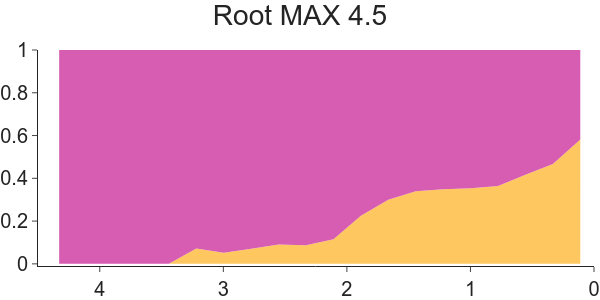

In [30]:
for rootage,n2dist in root2n2dist.items():
    max_time = max(n2dist.values())
    copy_merged = merged.copy()
    copy_merged.loc[:,'dist'] = [n2dist.get(_,max_time) for _ in copy_merged.index]

    col = 'dist'
    hist_d = np.histogram(copy_merged[col], bins=20, range = (0,max(copy_merged[col])) )
    xs = []
    ys1 = []
    ys2 = []
    ys = []
    left = 0
    for right in hist_d[1]:
        #print(left,right)
        sdf = copy_merged.loc[(copy_merged[col]>=left) & (copy_merged[col]<right),:]
        sdf = sdf.loc[[_ for _ in sdf.index if _.startswith('INO')],:]
        if sdf.shape[0]==0:continue
        num_anaerobe = len(sdf.index[sdf['A']<0.5])
        num_aerobe = sdf.shape[0]-num_anaerobe
        ys2.append(num_aerobe/sdf.shape[0])
        ys1.append(num_anaerobe/sdf.shape[0])
        ys.append(sdf.shape[0]/(copy_merged.shape[0]-len(reftre.get_leaf_names())))
        xs.append(max(copy_merged[col])-(left+right)/2)
        left = right
    import plotly.graph_objects as go
    fig = go.Figure()
    fig.add_scatter(x=np.array(xs)/10,y=ys2,mode='lines',opacity=0.7,fillcolor='#FFC75F', 
                    marker=dict(size=4),
                    name='Aerobe',fill='tozeroy',stackgroup='one',line=dict(width=0),showlegend=False)
    fig.add_scatter(x=np.array(xs)/10,y=ys1,mode='lines',opacity=0.7,fillcolor='#D65DB1',
                    name='Anaerobe',fill='tonexty',stackgroup='one',line=dict(width=0),showlegend=False)
    # fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
    fig.update_layout(height=300,width=600,xaxis_range=[4.5,0],yaxis_zeroline=False,yaxis_range=[-0.01,1],
                      margin_l=0,margin_r=0,margin_t=50,margin_b=0,
                      font_size=20,title_text=f"Root MAX {int(rootage)/10}",title_x=0.5,
                     template='simple_white')
    display(Image(fig.to_image()))

### varying root

In [3]:
from ete3 import Tree
from glob import glob
import pandas as pd
from tqdm import tqdm

In [4]:
root2n2dist = {}
reftre = Tree("/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/sequential_dating/root45_dated_20240328.nwk",1)
for tpath in glob('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/sequential_dating/varyingroot0328/r*_exactTimes.nwk'):
    tre = Tree(tpath)
    n2dist = {}
    for n1,n2 in tqdm(zip(reftre.traverse(),tre.traverse())):
        n2dist[n1.name] = tre.get_distance(n2)
    root2n2dist[tpath.split('/')[-1].split('_')[0].replace('r','')] = n2dist

161573it [00:09, 17898.04it/s]
161573it [00:08, 18526.50it/s]
161573it [00:08, 18174.97it/s]
161573it [00:08, 18538.17it/s]
161573it [00:08, 18581.47it/s]


In [20]:
merged = pd.read_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/ACE/Allnodes_predicted.tsv',sep='\t',index_col=0)
sub = merged.loc[[_ for _ in merged.index if _.startswith('INO')],:]
sub = sub.loc[sub.A>=sub.N,:]
sub

,A,N,dist
INO12950,0.508894,0.491106,40.281328
INO3701,0.523520,0.476480,40.701062
INO2868,0.504190,0.495810,32.296072
INO3700,0.608399,0.391601,33.921732
INO4664,0.630385,0.369615,35.111102
...,...,...,...
INO256,0.612662,0.387338,41.122440
INO182,0.547675,0.452325,32.653008
INO255,0.501789,0.498211,33.849808
INO683,0.503689,0.496311,40.485415


In [24]:
merged.loc[[_ for _ in merged.index if not _.startswith('INO')],:].shape

(80790, 3)

In [21]:
for k, v in  root2n2dist.items():
    m = max(list(v.values()))
    sub.loc[:,'d'] = [v[_] for _ in sub.index]
    print(k,round(m - sub['d'].min(),2))
# root2n2dist['42']['INO96']

42 26.35
45 27.5
40 24.81
35 22.2
37 23.44


In [191]:
import plotly.graph_objects as go
cs = px.colors.sequential.RdBu
time2xy = {}
fig = go.Figure()
for idx,(rootage,n2dist) in enumerate(sorted(root2n2dist.items())):
    max_time = max(n2dist.values())
    copy_merged = merged.copy()
    copy_merged.loc[:,'dist'] = [n2dist.get(_,max_time) for _ in copy_merged.index]

    col = 'dist'
    hist_d = np.histogram(copy_merged[col], bins=20, range = (0,max(copy_merged[col])) )
    xs = []
    ys1 = []
    ys2 = []
    ys = []
    left = 0
    for right in hist_d[1]:
        #print(left,right)
        sdf = copy_merged.loc[(copy_merged[col]>=left) & (copy_merged[col]<right),:]
        sdf = sdf.loc[[_ for _ in sdf.index if _.startswith('INO')],:]
        if sdf.shape[0]==0:continue
        num_anaerobe = len(sdf.index[sdf['A']<0.5])
        num_aerobe = sdf.shape[0]-num_anaerobe
        ys2.append(num_aerobe/sdf.shape[0])
        ys1.append(num_anaerobe/sdf.shape[0])
        ys.append(sdf.shape[0]/(copy_merged.shape[0]-len(reftre.get_leaf_names())))
        xs.append(max(copy_merged[col])-(left+right)/2)
        left = right
    time2xy[rootage] = (xs,ys2)
    fig.add_scatter(x=np.array(xs)/10,y=ys2,mode='lines',
                    #marker=dict(size=4),
                    name=f"Root {int(rootage)/10} Ga",
                    line=dict(width=2,color=cs[idx]))
    

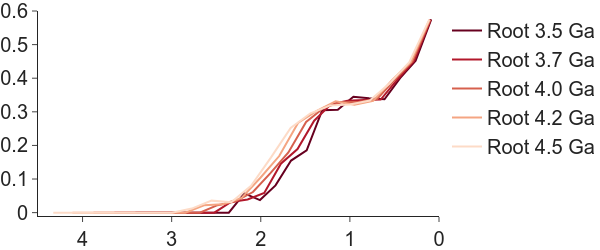

In [189]:
fig.update_layout(height=250,width=600,xaxis_range=[4.5,0],yaxis_zeroline=False,yaxis_range=[-0.01,0.6],
                  margin_l=0,margin_r=0,margin_t=0,margin_b=0,
                  font_size=20,#title_text=f"Root MAX {int(rootage)/10}",title_x=0.5,
                  template='simple_white')    
display(Image(fig.to_image()))

In [190]:
fig.write_image('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/Varying_root.pdf')

### O2 level from Guoxiong Chen 2022 NC 

In [224]:
aaa = '''25	-0.201677562
75	-0.20881733
125	-0.410852511
175	-0.645070262
225	-0.418781659
275	-0.231004161
325	-0.199868096
375	-0.202759316
425	-0.309763752
475	-0.437407066
525	-0.444233585
575	-0.422125102
625	-0.523232607
675	-1.074834682
725	-1.654627904
775	-2.020976677
825	-2.453741266
875	-2.616496774
925	-2.281821917
975	-2.212628562
1025	-2.431425673
1075	-2.555975326
1125	-2.658696827
1175	-2.732663315
1225	-2.786828672
1275	-2.757290202
1325	-2.298519618
1375	-1.980494551
1425	-2.046767816
1475	-2.508521423
1525	-2.857870085
1575	-2.94312129
1625	-2.891775212
1675	-2.743878194
1725	-2.746200849
1775	-3.232985644
1825	-4.492226171
1875	-5.535330486
1925	-5.703934979
1975	-5.036376683
2025	-4.510000184
2075	-4.720544504
2125	-4.946540091
2175	-5.106232339
2225	-5.27941501
2275	-5.51537294
2325	-5.949524104
2375	-6.341913177
2425	-6.430912005
2475	-6.421615325
2525	-6.48325709
2575	-6.738263666
2625	-6.98279049
2675	-7.071428027
2725	-7.087268324
2775	-7.085051009
2825	-7.125326595
2875	-7.16075015
2925	-7.135738641
2975	-7.082172493
3025	-7.074462048
3075	-7.05740683
3125	-7.10394796
3175	-7.179357935
3225	-7.186293114
3275	-7.136821162
3325	-7.100792404
3375	-7.079220091
3425	-7.076259048
3475	-7.101197943
3525	-7.171706662
3575	-7.206886337
3625	-7.207753146
3675	-7.295750067
3725	-7.315832449
3775	-7.188512918
3825	-7.058462585
3875	-7.102511574
3925	-7.157046351'''.split('\n')
Oxs = [int(_.split('\t')[0])/100 for _ in aaa]
Oys = [float(_.split('\t')[1]) for _ in aaa]


#for idx,(rootage,n2dist) in enumerate(sorted(root2n2dist.items())):
n2dist = root2n2dist['45']
max_time = max(n2dist.values())
copy_merged = merged.copy()
copy_merged.loc[:,'dist'] = [max_time-n2dist.get(_,max_time) for _ in copy_merged.index]

col = 'dist'
xs = []
ys1 = []
left = 0
for right in Oxs[1:]:
    right = right
    sdf = copy_merged.loc[(copy_merged[col]>=left) & (copy_merged[col]<right),:]
    sdf = sdf.loc[[_ for _ in sdf.index if _.startswith('INO')],:]
    if sdf.shape[0]==0:
        continue
    num_anaerobe = len(sdf.index[sdf['A']<0.5])
    num_aerobe = sdf.shape[0]-num_anaerobe
    ys1.append(num_aerobe/sdf.shape[0])
    xs.append((left+right)/2)
    left = right

In [238]:
from scipy.stats import ranksums

In [245]:
ranksums(time2xy['45'][1],Oys_1,alternative='greater')

RanksumsResult(statistic=-6.884765791223402, pvalue=0.9999999999971059)

In [ ]:
import numpy as np
np.corrcoef(time2xy['45'][1],Oys_1)

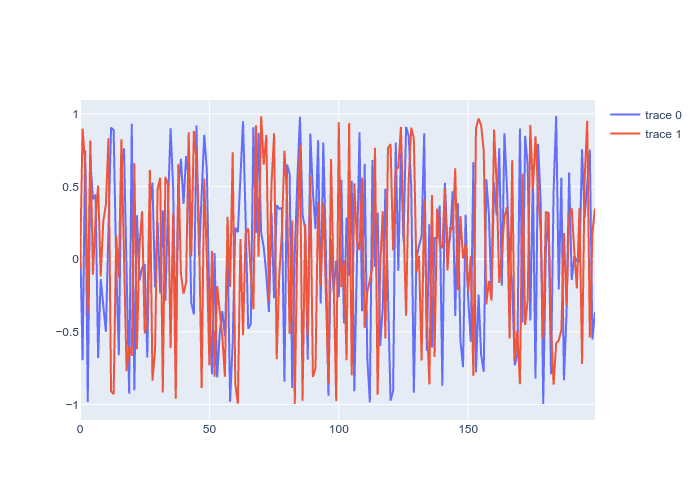

In [249]:
import numpy as np
from scipy.stats import ranksums
fig = go.Figure()
rng = np.random.default_rng()
sample1 = rng.uniform(-1, 1, 200)
sample2 = rng.uniform(-1, 1, 200) # a shifted distribution
fig.add_scatter(x=list(range(len(sample1))),y=sample1)
fig.add_scatter(x=list(range(len(sample2))),y=sample2)
#fig.update_
display(Image(fig.to_image()))

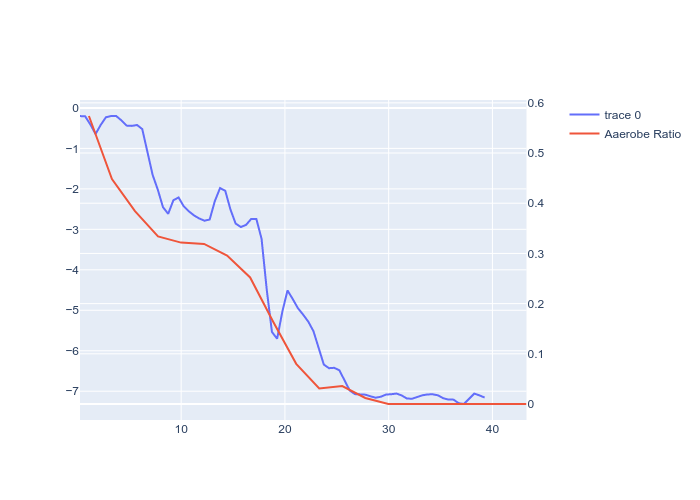

In [234]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_scatter(x=Oxs,y=Oys)
fig.add_scatter(x=time2xy['45'][0],y=time2xy['45'][1],secondary_y=True,name='Aaerobe Ratio')
#fig.update_
display(Image(fig.to_image()))

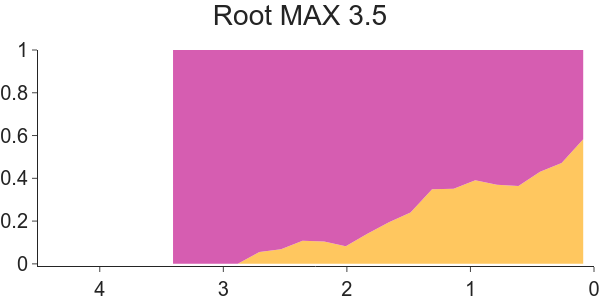

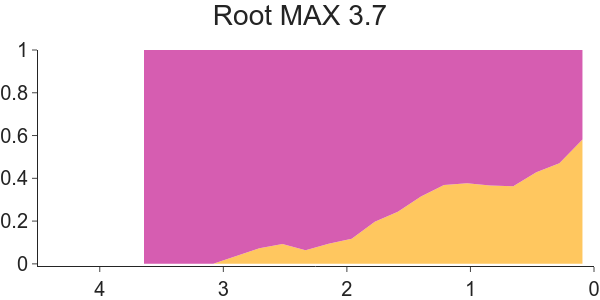

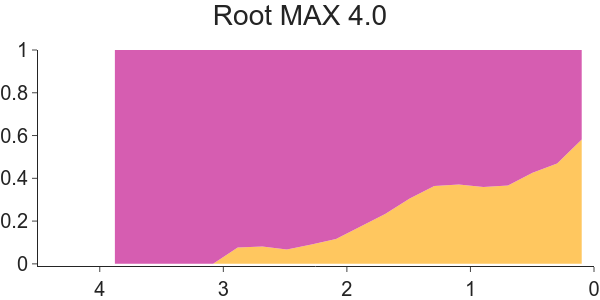

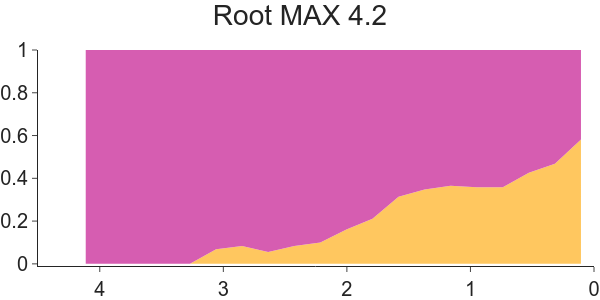

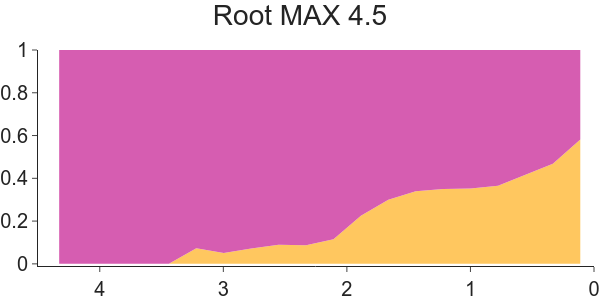

In [103]:
for rootage,n2dist in sorted(root2n2dist.items()):
    max_time = max(n2dist.values())
    copy_merged = merged.copy()
    copy_merged.loc[:,'dist'] = [n2dist.get(_,max_time) for _ in copy_merged.index]

    col = 'dist'
    hist_d = np.histogram(copy_merged[col], bins=20, range = (0,max(copy_merged[col])) )
    xs = []
    ys1 = []
    ys2 = []
    ys = []
    left = 0
    for right in hist_d[1]:
        #print(left,right)
        sdf = copy_merged.loc[(copy_merged[col]>=left) & (copy_merged[col]<right),:]
        sdf = sdf.loc[[_ for _ in sdf.index if _.startswith('INO')],:]
        if sdf.shape[0]==0:continue
        num_anaerobe = len(sdf.index[sdf['A']<0.5])
        num_aerobe = sdf.shape[0]-num_anaerobe
        ys2.append(num_aerobe/sdf.shape[0])
        ys1.append(num_anaerobe/sdf.shape[0])
        ys.append(sdf.shape[0]/(copy_merged.shape[0]-len(reftre.get_leaf_names())))
        xs.append(max(copy_merged[col])-(left+right)/2)
        left = right
    import plotly.graph_objects as go
    fig = go.Figure()
    fig.add_scatter(x=np.array(xs)/10,y=ys2,mode='lines',opacity=0.7,fillcolor='#FFC75F', 
                    marker=dict(size=4),
                    name='Aerobe',fill='tozeroy',stackgroup='one',line=dict(width=0),showlegend=False)
    fig.add_scatter(x=np.array(xs)/10,y=ys1,mode='lines',opacity=0.7,fillcolor='#D65DB1',
                    name='Anaerobe',fill='tonexty',stackgroup='one',line=dict(width=0),showlegend=False)
    # fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
    fig.update_layout(height=300,width=600,xaxis_range=[4.5,0],yaxis_zeroline=False,yaxis_range=[-0.01,1],
                      margin_l=0,margin_r=0,margin_t=50,margin_b=0,
                      font_size=20,title_text=f"Root MAX {int(rootage)/10}",title_x=0.5,
                     template='simple_white')
    display(Image(fig.to_image()))
    #break

## internal nodes of WoL

In [290]:
import io
def parse_r(infile,fea='Y'):
    ko = infile.split('/')[-2].split('_')[0]
    rows = open(infile).readlines()
    header = [_ for _ in rows if _.startswith('FIELD_LABELS')]
    header = header[0].strip().split('\t')[1:]
    data = [idx for idx,_ in enumerate(rows) if _.startswith('OROOT')]
    data = rows[data[0]:]
    _df = pd.read_csv(io.StringIO(''.join(data)),sep='\t',index_col=0,header=None)
    _df = _df.loc[:,[3,4]]
    _df.columns = header
    _df.loc[:,ko] = [v for v in _df[fea]]
    return _df[[ko]]


In [287]:
wol_ances = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/eachKO_bs/merged_predicted.tsv',sep='\t',index_col=0).reindex(columns=top50).fillna(0)
wol_ances_predicted = wol_ances.copy()
wol_ances_predicted.loc[:,'gbdt'] = gbdt_model.predict(xgb.DMatrix(wol_ances))
wol_ances_predicted.loc[:,'LR'] = LR_model.predict(wol_ances)
wol_ances_predicted.loc[:,'LR prob'] = LR_model.predict_proba(wol_ances)[:,LR_model.classes_==1].reshape(-1)

In [250]:
from api_tools.itol_func import to_color_branch,to_color_range
text = to_color_range({k: 'Aerobe' if v==1 else "Anaerobe" for k,v in wol_ances_predicted['LR'].to_dict().items()},
               {'Aerobe':'#ffc75f',
               'Anaerobe':'#d65db1'})
with open('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/eachKO_bs/colorrange_itol.txt','w') as f1:
    f1.write(text)
wol_ances_predicted.to_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/eachKO_bs/merged_predicted.tab',sep='\t')

In [255]:
pred_results = pd.read_excel('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/bacteria_top50_predictions.xlsx',index_col=0)

In [259]:
d1 = pred_results[['LR prob']]
d1.columns = ['A']
d1.loc[:,'N'] = 1-d1['A']
d1.loc[:,'dist'] = [n2dist.get(_,0) for _ in d1.index]
d2 = wol_ances_predicted[['LR prob']]
d2.columns = ['A']
d2.loc[:,'N'] = 1-d2['A']
d2.loc[:,'dist'] = [n2dist.get(_,0) for _ in d2.index]
merged = pd.concat([d1,d2],axis=0)
merged.to_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/eachKO_bs/Allnodes_predicted.tab',sep='\t')

In [288]:
wol_ances_predicted

,K00526,K00176,K00254,K02275,K02276,K21567,K00164,K01589,K00457,K04063,...,K00867,K03737,K17828,K01895,K00674,K01903,K00627,gbdt,LR,LR prob
0,,,,,,,,,,,,,,,,,,,,,
OROOT,0.000430,0.999982,0.000261,0.017465,0.000927,0.001017,0.000454,0.000301,0.008833,0.006600,...,0.000144,0.000719,0.999958,0.920885,0.000238,0.002925,0.001113,0.024519,0,0.006489
N7,0.000430,0.999982,0.000261,0.017465,0.000927,0.001017,0.000454,0.000301,0.008833,0.006600,...,0.000144,0.000719,0.999958,0.920885,0.000238,0.002925,0.001113,0.024519,0,0.006489
N13,0.004326,0.998443,0.002073,0.010411,0.009597,0.010898,0.004131,0.003163,0.068241,0.064713,...,0.000994,0.014299,0.999368,0.165877,0.001814,0.016167,0.011313,0.024519,0,0.002668
N14,0.000062,1.000000,0.000011,0.067088,0.000827,0.000056,0.000021,0.000074,0.020651,0.010264,...,0.000006,0.000534,0.999998,0.983123,0.000015,0.036494,0.002574,0.086898,0,0.009196
N21,0.065874,0.800802,0.040049,0.102107,0.098571,0.102764,0.061190,0.046245,0.238494,0.234425,...,0.024239,0.077201,0.989716,0.735584,0.036363,0.076830,0.108957,0.024519,0,0.008422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N10570,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.954987,1,0.932308
N10571,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.954987,1,0.932308
N10572,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.954987,1,0.932308


### bs directly

In [291]:
from ete3 import Tree
intree = '/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/ref_tree.newick'
tre = Tree(intree,3)
name2dist = {n.name:n.get_distance(tre) for n in tre.traverse()}
r_df = parse_r('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_predicted/complex_habitat_prob.itol.txt',fea='A')
r_df = r_df.reindex(wol_ances_predicted.index)
wol_ances_predicted.loc[:,'recon pheno prob'] = r_df['LR']
wol_ances_predicted.loc[:,'dist to root'] = [name2dist.get(n,0) for n in wol_ances_predicted.index]
wol_ances_predicted.loc[:,'name'] = wol_ances_predicted.index

In [294]:
dist_df = {}
tre = Tree('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/sequential_dating/r45_withsishuo/root45_dated.nwk',format=3)
n2dist = {}
for a in tqdm(tre.traverse()):
    n2dist[a.name] = tre.get_distance(a)
max_time = max(n2dist.values())
sdf = wol_ances_predicted.loc[:,['gbdt','LR prob', 'recon pheno prob','LR']]
sdf.columns = ['Aerobe probility (GBDT)','Aerobe probility (LR)','Aerobe probility (bayestraits)','Phenotype']
sdf.loc[:,'Phenotype'] = ['Anaerobe' if _==0 else 'Aerobe' for _ in sdf['Phenotype']]
sdf.loc[:,'Time estimates/year'] = [max_time-n2dist.get(n,0) for n in sdf.index]
sdf.to_excel('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/bsOnly_predicted.xlsx')

21149it [00:00, 22680.64it/s]


In [302]:
d2 = sdf.loc[:,['Aerobe probility (bayestraits)']]
d2.columns = ['A']
d2.loc[:,'N'] = 1- d2['A']
d2.loc[:,'dist'] = [n2dist.get(_,0) for _ in d2.index]

In [303]:
pred_results = pd.read_excel('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/bacteria_top50_predictions.xlsx',index_col=0)
d1 = pred_results[['LR prob']]
d1.columns = ['A']
d1.loc[:,'N'] = 1-d1['A']
d1.loc[:,'dist'] = [n2dist.get(_,0) for _ in d1.index]
merged = pd.concat([d1,d2],axis=0)
merged

,A,N,dist
G000212395,0.005346,0.994654,36.868710
G000021645,0.002529,0.997471,36.868640
G000020965,0.002529,0.997471,36.868640
G001871575,0.008481,0.991519,36.868700
G000284335,0.007771,0.992229,36.868700
...,...,...,...
N10570,1.000000,0.000000,36.773798
N10571,1.000000,0.000000,36.867516
N10572,1.000000,0.000000,36.802386
N10573,1.000000,0.000000,36.817144


In [304]:
merged.to_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/bsOnly_predicted.tab',sep='\t')

100%|██████████| 21/21 [00:00<00:00, 205.79it/s]


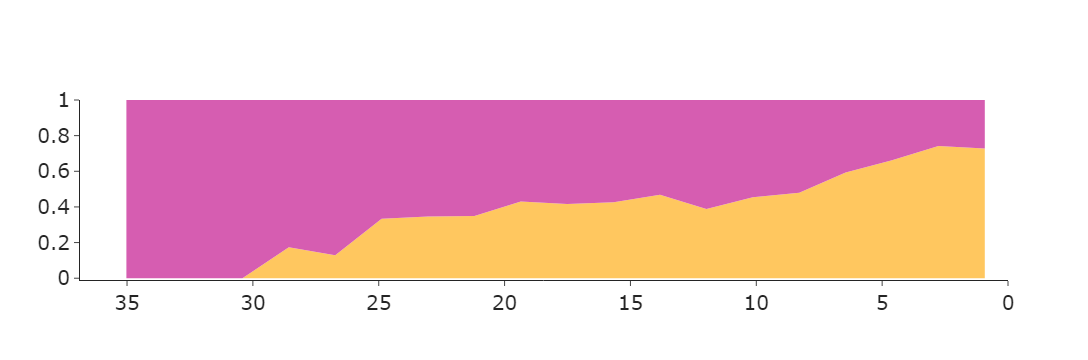

In [307]:
col = 'dist'
hist_d = np.histogram(merged[col], bins=20, range = (0,max(merged[col])) )
xs = []
ys1 = []
ys2 = []
ys = []
left = 0
for right in tqdm(hist_d[1]):
    #print(left,right)
    sdf = merged.loc[(merged[col]>=left) & (merged[col]<right),:]
    sdf = sdf.loc[[_ for _ in sdf.index if _.startswith('N')],:]
    if sdf.shape[0]==0:continue
    num_anaerobe = len(sdf.index[sdf['A']<0.5])
    num_aerobe = sdf.shape[0]-num_anaerobe
    ys2.append(num_aerobe/sdf.shape[0])
    ys1.append(num_anaerobe/sdf.shape[0])
    ys.append(sdf.shape[0]/(merged.shape[0]-d1.shape[0]))
    xs.append(max(merged[col])-(left+right)/2)
    left = right
import plotly.graph_objects as go
fig = go.Figure()
fig.add_scatter(x=xs,y=ys2,mode='lines',opacity=0.7,fillcolor='#FFC75F', 
                marker=dict(size=4),
                name='Aerobe',fill='tozeroy',stackgroup='one',line=dict(width=0),showlegend=False)
fig.add_scatter(x=xs,y=ys1,mode='lines',opacity=0.7,fillcolor='#D65DB1',
                name='Anaerobe',fill='tonexty',stackgroup='one',line=dict(width=0),showlegend=False)
# fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
fig.update_layout(height=300,width=600,xaxis_range=[max(merged[col]),0],yaxis_zeroline=False,yaxis_range=[-0.01,1],
                  font_size=20,
                 template='simple_white')
fig.show()

### ACE directly

In [320]:

merged = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/eachKO_ACE/Allnodes_predicted.tab',sep='\t',index_col=0)

In [321]:
d = pd.read_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/WoL/Bisse_output/sampling/8452.apeace_ACE.tsv',sep='\t',index_col=0)
d.index = ['OROOT'] + list(d.index)[1:]
merged.loc[d.index,'A'] = d['1']
merged.loc[d.index,'N'] = d['0']

100%|██████████| 51/51 [00:00<00:00, 284.64it/s]


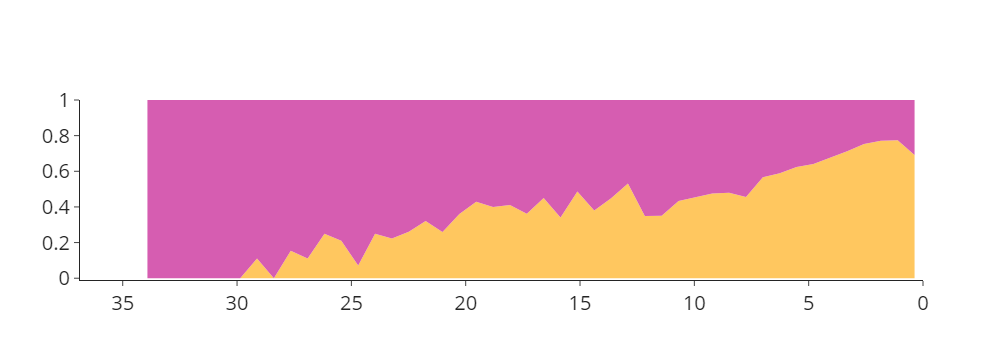

In [323]:
col = 'dist'
hist_d = np.histogram(merged[col], bins=50, range = (0,max(merged[col])) )
xs = []
ys1 = []
ys2 = []
ys = []
left = 0
for right in tqdm(hist_d[1]):
    #print(left,right)
    sdf = merged.loc[(merged[col]>=left) & (merged[col]<right),:]
    sdf = sdf.loc[[_ for _ in sdf.index if _.startswith('N')],:]
    if sdf.shape[0]==0:continue
    num_anaerobe = len(sdf.index[sdf['A']<0.5])
    num_aerobe = sdf.shape[0]-num_anaerobe
    ys2.append(num_aerobe/sdf.shape[0])
    ys1.append(num_anaerobe/sdf.shape[0])
    ys.append(sdf.shape[0]/(merged.shape[0]-d1.shape[0]))
    xs.append(max(merged[col])-(left+right)/2)
    left = right
import plotly.graph_objects as go
fig = go.Figure()
fig.add_scatter(x=xs,y=ys2,mode='lines',opacity=0.7,fillcolor='#FFC75F', 
                marker=dict(size=4),
                name='Aerobe',fill='tozeroy',stackgroup='one',line=dict(width=0),showlegend=False)
fig.add_scatter(x=xs,y=ys1,mode='lines',opacity=0.7,fillcolor='#D65DB1',
                name='Anaerobe',fill='tonexty',stackgroup='one',line=dict(width=0),showlegend=False)
# fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
fig.update_layout(height=300,width=600,xaxis_range=[max(merged[col]),0],yaxis_zeroline=False,yaxis_range=[-0.01,1],
                  font_size=20,
                 template='simple_white')
fig.show()

### ACE-first

In [ ]:
dfs = []
for f in tqdm(glob('/home-user/thliao/project/ML_oxygen/testing_sets/WoL/eachKO_ACE/*.anc')):
    d = pd.read_csv(f,sep='\t',index_col=0)
    d.index = ['OROOT'] + list(d.index)[1:]
    name = f.split('/')[-1].split('.')[0]
    d.loc[:,name] = [r[1] for _,r in d.iterrows()]
    dfs.append(d.loc[:,[name]])
total_df = pd.concat(dfs,axis=1)


100%|██████████| 50/50 [00:14<00:00,  3.43it/s]


In [ ]:
total_df = total_df.reindex(columns=top50).fillna(0)
wol_ances_predicted = total_df.copy()
wol_ances_predicted.loc[:,'gbdt'] = gbdt_model.predict(xgb.DMatrix(total_df))
wol_ances_predicted.loc[:,'LR'] = LR_model.predict(total_df)
wol_ances_predicted.loc[:,'LR prob'] = LR_model.predict_proba(total_df)[:,LR_model.classes_==1].reshape(-1)

In [265]:
tre = Tree('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/sequential_dating/r45_withsishuo/root45_dated.nwk',format=3)
n2dist = {}
for a in tqdm(tre.traverse()):
    n2dist[a.name] = tre.get_distance(a)

21149it [00:00, 22971.66it/s]


In [266]:
pred_results = pd.read_excel('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/bacteria_top50_predictions.xlsx',index_col=0)
d1 = pred_results[['LR prob']]
d1.columns = ['A']
d1.loc[:,'N'] = 1-d1['A']
d1.loc[:,'dist'] = [n2dist.get(_,0) for _ in d1.index]
d2 = wol_ances_predicted[['LR prob']]
d2.columns = ['A']
d2.loc[:,'N'] = 1-d2['A']
d2.loc[:,'dist'] = [n2dist.get(_,0) for _ in d2.index]
merged = pd.concat([d1,d2],axis=0)
merged

,A,N,dist
G000212395,0.005346,0.994654,36.868710
G000021645,0.002529,0.997471,36.868640
G000020965,0.002529,0.997471,36.868640
G001871575,0.008481,0.991519,36.868700
G000284335,0.007771,0.992229,36.868700
...,...,...,...
N10507,0.948731,0.051269,36.683862
N10527,0.948733,0.051267,36.692372
N10545,0.948733,0.051267,36.743252
N10528,0.948731,0.051269,36.685401


In [267]:
merged.to_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/eachKO_ACE/Allnodes_predicted.tab',sep='\t')

100%|██████████| 51/51 [00:00<00:00, 310.52it/s]


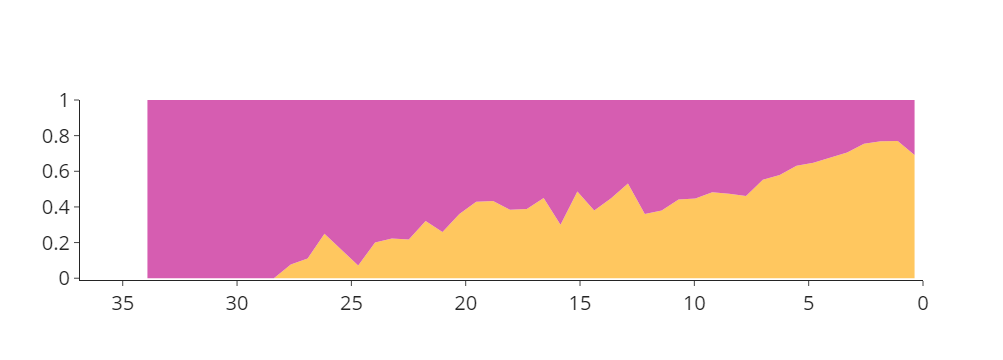

In [325]:
merged = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/eachKO_ACE/Allnodes_predicted.tab',sep='\t',index_col=0)
col = 'dist'
hist_d = np.histogram(merged[col], bins=50, range = (0,max(merged[col])) )
xs = []
ys1 = []
ys2 = []
ys = []
left = 0
for right in tqdm(hist_d[1]):
    #print(left,right)
    sdf = merged.loc[(merged[col]>=left) & (merged[col]<right),:]
    sdf = sdf.loc[[_ for _ in sdf.index if _.startswith('N')],:]
    if sdf.shape[0]==0:continue
    num_anaerobe = len(sdf.index[sdf['A']<0.5])
    num_aerobe = sdf.shape[0]-num_anaerobe
    ys2.append(num_aerobe/sdf.shape[0])
    ys1.append(num_anaerobe/sdf.shape[0])
    ys.append(sdf.shape[0]/(merged.shape[0]-d1.shape[0]))
    xs.append(max(merged[col])-(left+right)/2)
    left = right
import plotly.graph_objects as go
fig = go.Figure()
fig.add_scatter(x=xs,y=ys2,mode='lines',opacity=0.7,fillcolor='#FFC75F', 
                marker=dict(size=4),
                name='Aerobe',fill='tozeroy',stackgroup='one',line=dict(width=0),showlegend=False)
fig.add_scatter(x=xs,y=ys1,mode='lines',opacity=0.7,fillcolor='#D65DB1',
                name='Anaerobe',fill='tonexty',stackgroup='one',line=dict(width=0),showlegend=False)
# fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
fig.update_layout(height=300,width=600,xaxis_range=[max(merged[col]),0],yaxis_zeroline=False,yaxis_range=[-0.01,1],
                  font_size=20,
                 template='simple_white')
fig.show()

### compare two methods

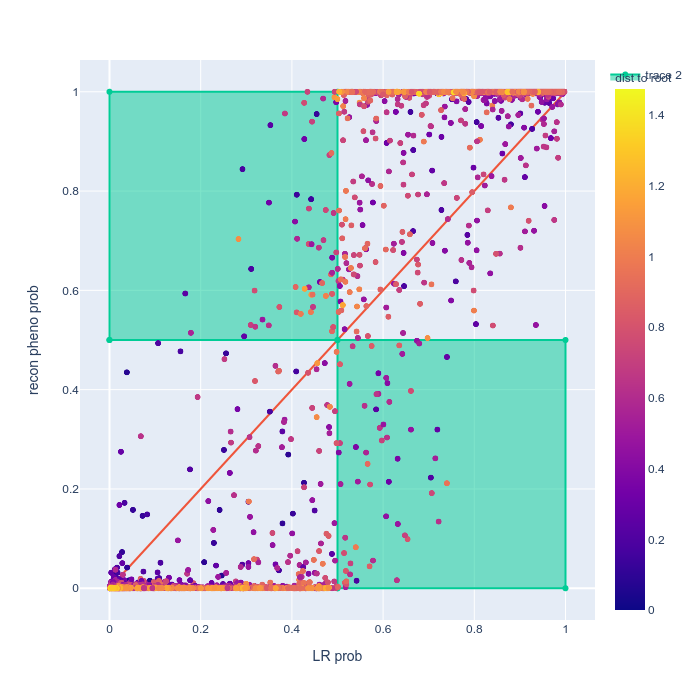

In [271]:
import plotly.express as px
fig = px.scatter(wol_ances_predicted,
                 x='LR prob',y='recon pheno prob',color='dist to root',
                 text='name')
fig.update_traces(mode='markers')
fig.add_scatter(x=[0,1],y=[0,1],mode='lines',showlegend=False)

fig.add_trace( go.Scatter(x=[0.5,1,1,0.5,0.5,None,0,0.5,0.5,0,0], y=[0,0,0.5,0.5,0,None,0.5,0.5,1,1,0.5], fill="toself"))

fig.layout.height = 700
fig.layout.width = 700
display(Image(fig.to_image()))

# most contrasting nodes distribtued nearing the root positions.

# WoL

In [11]:
wol_ances = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL_top50_bin.tab',sep='\t',index_col=0).reindex(columns=top50).fillna(0)

wol_ances_predicted = wol_ances.copy()
wol_ances_predicted.loc[:,'gbdt'] = gbdt_model.predict(xgb.DMatrix(wol_ances))
wol_ances_predicted.loc[:,'LR'] = LR_model.predict(wol_ances)
wol_ances_predicted.loc[:,'LR prob'] = LR_model.predict_proba(wol_ances)[:,LR_model.classes_==1].reshape(-1)

In [106]:
from api_tools import pie_chart

c = {k:'Anaerobe' if v<=0.5 else 'Aerobe' for k,v in wol_ances_predicted['LR prob'].to_dict().items()}
text = to_color_strip(c,{"Aerobe":"#FFC75F",
                         "Anaerobe":"#D65DB1"},other_params={'margin':"50","strip_width":"50"},
                      dataset_name="LR prediction")
with open('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_colorstrip.txt','w') as f1:
    f1.write(text)

with open("/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_predicted_state.txt",'w') as f1:    
    for k,v in c.items():
        p = 'A' if v=='Aerobe' else "N"
        f1.write(f"{k}\t{p}\n")

In [108]:
wol_ances_predicted.to_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_predicted.tab',sep='\t',index=1,index_label=wol_ances_predicted.index.name)

## reltime dating

In [242]:
dist_df = {}
tre = Tree('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/sequential_dating/r45_withsishuo/root45_dated.nwk',format=3)
n2dist = {}
for a in tqdm(tre.traverse()):
    n2dist[a.name] = tre.get_distance(a)


21149it [00:00, 22708.35it/s]


### table 1 and fig

In [244]:
from tqdm import tqdm
import pandas as pd
import io
from ete3 import Tree

p_df = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_predicted.tab',sep='\t',index_col=0)
subp_df = p_df.loc[:,['LR prob']]
subp_df.columns=['A']


infile = '/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_predicted/complex_habitat_prob.itol.txt'
rows = open(infile).readlines()
header = [_ for _ in rows if _.startswith('FIELD_LABELS')]
header = header[0].strip().split('\t')[1:]
data = [idx for idx,_ in enumerate(rows) if _.startswith('OROOT')]
data = rows[data[0]:]
_df = pd.read_csv(io.StringIO(''.join(data)),sep='\t',index_col=0,header=None)
_df = _df.loc[:,[3,4]]
_df.columns = header
_df = pd.concat([_df,subp_df],axis=0)
_df.loc[:,'N'] = 1-_df['A']
def get_state(i):
    if i['A']>=0.5:
        return 'Aerobe'
    else:
        return 'Anaerobe'
all_n = [_.name for _ in tre.traverse()]
_df.loc[:,'dist'] = [0]+[n2dist.get(a,np.nan) for a in tqdm(_df.index[1:])]
sub_df = _df.loc[~_df['dist'].isna(),:]
sub_df.loc[:,'re-dist'] = sub_df['dist'] * (45/max(sub_df['dist']))   # normalized to 45
sub_df.to_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_predicted/summarized_prob.tsv',sep='\t',index=1)
sub_df

100%|██████████| 19026/19026 [00:00<00:00, 1351502.69it/s]


,A,N,dist,re-dist
OROOT,0.000156,0.999844,0.000000,0.000000
N7,0.000156,0.999844,2.841190,3.467802
N13,0.001127,0.998873,5.190120,6.334779
N14,0.000006,0.999994,5.422610,6.618543
N21,0.027405,0.972595,9.390910,11.462035
...,...,...,...,...
G000014785,0.982760,0.017240,36.868685,44.999916
G900129375,0.988012,0.011988,36.868645,44.999867
G001790045,0.328607,0.671393,36.868700,44.999934
G001798395,0.100467,0.899533,36.868704,44.999939


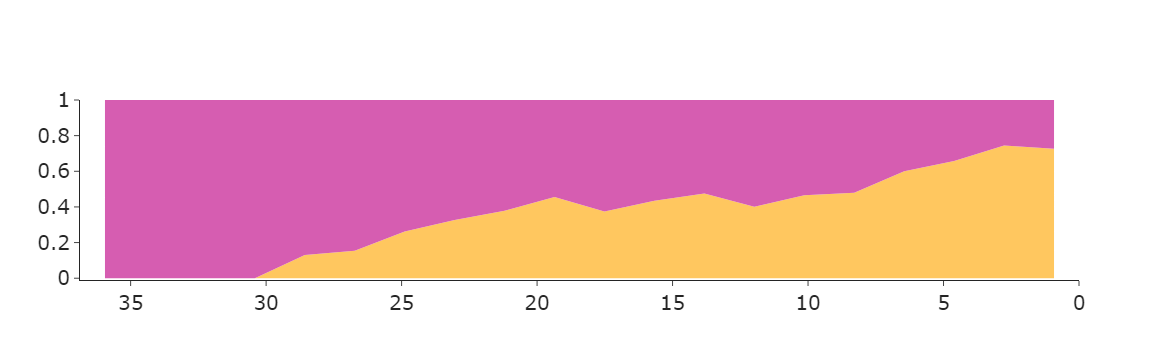

In [271]:
#sub_df = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_predicted/summarized_prob.tsv',sep='\t',index_col=0)
sub_df = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/eachKO_bs/Allnodes_predicted.tab',sep='\t',index_col=0)
# tmp = pd.read_csv('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/WoL/Bisse_output/sampling/8452.apeace_ACE.tsv',sep='\t',index_col=0)
# tmp.index = ['OROOT'] + list(tmp.index[1:])
# sub_df.loc[tmp.index,'A'] = tmp['1']
# sub_df.loc[tmp.index,'N'] = tmp['0']

col = 'dist'
hist_d = np.histogram(sub_df[col], bins=20, range = (0,max(sub_df[col])) )
xs = []
ys1 = []
ys2 = []
ys = []
left = 0
for right in hist_d[1]:
    #print(left,right)
    sdf = sub_df.loc[(sub_df[col]>=left) & (sub_df[col]<right),:]
    sdf = sdf.loc[[_ for _ in sdf.index if not _.startswith('G')],:]
    if sdf.shape[0]==0:continue
    num_anaerobe = len(sdf.index[sdf['A']<0.5])
    num_aerobe = sdf.shape[0]-num_anaerobe
    ys2.append(num_aerobe/sdf.shape[0])
    ys1.append(num_anaerobe/sdf.shape[0])
    ys.append(sdf.shape[0]/(sub_df.shape[0]-10575))
    xs.append(max(sub_df[col])-(left+right)/2)
    left = right
import plotly.graph_objects as go
fig = go.Figure()

fig.add_scatter(x=xs,y=ys2,mode='lines',opacity=0.7,fillcolor='#FFC75F', 
                marker=dict(size=4),
                name='Aerobe',fill='tozeroy',stackgroup='one',line=dict(width=0),showlegend=False)
fig.add_scatter(x=xs,y=ys1,mode='lines',opacity=0.7,fillcolor='#D65DB1',
                name='Anaerobe',fill='tonexty',stackgroup='one',line=dict(width=0),showlegend=False)
# fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
fig.update_layout(height=300,width=600,xaxis_range=[max(sub_df[col]),0],yaxis_zeroline=False,yaxis_range=[-0.01,1],
                  font_size=20,
                 template='simple_white')
fig.show()
#fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/sequential_dating/r45_withsishuo/ratio_distributions.pdf')

### table 2

In [111]:
from tqdm import tqdm
import pandas as pd
import io
from ete3 import Tree

p_df = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_predicted.tab',sep='\t',index_col=0)
internal_node_df = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/eachKO_bs/merged_predicted.tab',sep='\t',index_col=0)
_df = pd.concat([internal_node_df,p_df],axis=0)
_df = _df.loc[:,['LR prob']]
_df.columns=['A']

def get_state(i):
    if i['A']>=0.5:
        return 'Aerobe'
    else:
        return 'Anaerobe'
all_n = [_.name for _ in tre.traverse()]
_df.loc[:,'dist'] = [0]+[n2dist.get(a,np.nan) for a in tqdm(_df.index[1:])]
sub_df = _df.loc[~_df['dist'].isna(),:]
sub_df.loc[:,'re-dist'] = sub_df['dist'] * (45/max(sub_df['dist']))   # normalized to 45
#sub_df.to_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_predicted/summarized_prob.tsv',sep='\t',index=1)
sub_df

100%|██████████| 19026/19026 [00:00<00:00, 1224709.22it/s]


,A,dist,re-dist
OROOT,0.006489,0.000000,0.000000
N7,0.006489,4.045870,4.147333
N13,0.002668,6.721220,6.889777
N14,0.009196,5.456440,5.593278
N21,0.008422,11.265680,11.548204
...,...,...,...
G000014785,0.982760,43.899009,44.999920
G900129375,0.988012,43.898993,44.999904
G001790045,0.328607,43.899000,44.999911
G001798395,0.100467,43.899005,44.999916


In [29]:
sub_df.to_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/sequential_dating/r45_withsishuo/summarized_prob.tsv',sep='\t',index=1)

## earliest aerobe

The earliest aerobe node (N146) should be the total group of cyanobacteria. (very interesting) There are also some mis-assigned firmicutes/terrbacteria group bacteria.

Thus, this earliest aerobe is well-consistent with the extant knowledge.

![earliest aerobe](earliest_aerobe.png)

In [ ]:
tre = Tree('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/sequential_dating/r45_withsishuo/root45_dated.nwk',format=3)
name2node = {_.name: _ for _ in tre.traverse()}

tmp_df = sub_df.loc[sub_df['A']>0.5].sort_values('dist')
tmp_df.loc[:,'dist'] = max(tmp_df['dist'])-tmp_df['dist']
tmp_df

In [74]:
wol_g2tax = {_.split(',')[0]:_.split(',')[2] for _ in open('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/tax_colorstrip.txt').read().split('\n') if len(_.split(','))==3 and _.startswith('G')}
tax_df.loc[tre.get_leaf_names(),,"wol taxgroup"] = [wol_g2tax[_] for _ in tre.get_leaf_names()]

a = []
sub_df.loc[:,'dominated phylum'] =''
for n,row in tqdm(sub_df.iterrows(),total=sub_df.shape[0]):
    if n=='OROOT':
        continue
    else:
        sub_taxdf = tax_df.reindex(name2node[n].get_leaf_names())
        p2num = sub_taxdf.groupby('wol taxgroup').size().to_dict()
        if not p2num:
            a.append('')
            continue
        p = sorted(p2num.items(),key=lambda x:x[1])[-1][0]
        a.append(p)
sub_df.loc[:,'dominated phylum'] = [''] + a

In [ ]:
col = 're-dist'
left = 0
hist_d = np.histogram(sub_df[col], bins=20, range = (0,max(sub_df[col])) )
for right in hist_d[1]:
    #print(left,right)
    sdf = sub_df.loc[(sub_df[col]>=left) & (sub_df[col]<right),:]
    sdf = sdf.loc[[_ for _ in sdf.index if not _.startswith('G')],:]
    aerobe_sdf = sdf.loc[sdf['A']>=0.5,:]
    print(max(sub_df[col])-left,max(sub_df[col])-right,aerobe_sdf.shape[0])    
    if sdf.shape[0]==0:
        left = right
        continue
    if aerobe_sdf.shape[0]==0:
        left = right
        continue
    n2new_info = {}
    for n in aerobe_sdf.index:
        all_ids = name2node[n].get_leaf_names()
        n2new_info[n] = [len(all_ids),aerobe_sdf.loc[n,'dominated phylum']]
    print(max(sub_df[col])-(left+right)/2,
          n2new_info)
    left = right

In [97]:
col = 're-dist'
left,right = max(sub_df[col])-31.5,max(sub_df[col])-29.25
sdf = sub_df.loc[(sub_df[col]>=left) & (sub_df[col]<right),:]
sdf = sdf.loc[[_ for _ in sdf.index if not _.startswith('G')],:]
aerobe_sdf = sdf.loc[sdf['A']>=0.5,:]
aerobe_sdf

,A,N,dist,re-dist,dominated phylum
N146,0.955024,0.044976,17.315722,15.072253,Cyanobacteria
N736,0.792623,0.207377,17.951688,15.625821,Chloroflexi
N743,0.783548,0.216452,18.088980,15.745325,Actinobacteria
N1360,0.959380,0.040620,17.752664,15.452583,Chlamydiae


In [103]:
test_d = xgb.DMatrix(wol_ances)
shap_vals = gbdt_model.predict(test_d, pred_contribs=True)
shap_vals = shap_vals[:, :-1]  # the last column is the bias term, needed to be removed
shap_df = pd.DataFrame(shap_vals,index=wol_ances.index,columns=wol_ances.columns)

In [107]:
earliestN2shap_df  = {}
for n in aerobe_sdf.index:
    sub_shapdf = shap_df.loc[name2node[n].get_leaf_names(),:]
    earliestN2shap_df[n] = sub_shapdf

In [111]:
for k,sdf in earliestN2shap_df.items():
    print(k)
    print(sdf.abs().mean(0).sort_values()[-5:])

N146
K05919    0.220551
K07146    0.245689
K02259    0.266596
K00526    0.343724
K02257    0.612769
dtype: float32
N736
K00177    0.218639
K00526    0.241990
K00164    0.275049
K18707    0.295661
K02257    0.568367
dtype: float32
N743
K06886    0.183517
K05919    0.184063
K00632    0.244695
K00164    0.314601
K02257    0.720781
dtype: float32
N1360
K05919    0.220073
K00164    0.239681
K18707    0.339067
K07146    0.340656
K02257    0.886574
dtype: float32


---

## vis (along time scale, ratio of aerobes/anaerobes)

### wol

In [183]:
dist_df = {}
tre = Tree('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/sequential_dating/root45_dated.nwk',format=3)
n2dist = {}
for a in tqdm(tre.traverse()):
    n2dist[a.name] = tre.get_distance(a)


161573it [00:09, 16817.60it/s]


In [ ]:
tre = Tree('/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/sequential_dating/root45_dated.nwk',format=3)
ns = len([n for n in tre.traverse() if not n.is_leaf()])
ns

80786

In [184]:
d = pd.read_excel('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/GTDB_r214/bacteria_top50_predictions.xlsx',index_col=0)

In [185]:
sub_df = d.loc[:,['LR prob']]
sub_df.loc[:,'A']
sub_df.loc[:,'N'] = 1-sub_df['A']
sub_df.loc[:,'dist'] = [n2dist[_] for _ in sub_df.index]

,gbdt prob,LR,LR prob,predicted phenotype
GB_GCA_001829155.1,0.045273,0,0.018411,anaerobe
GB_GCA_025061835.1,0.040847,0,0.031078,anaerobe
RS_GCF_900112165.1,0.314584,0,0.270815,anaerobe
GB_GCA_001829415.1,0.024519,0,0.003939,anaerobe
GB_GCA_020059465.1,0.024519,0,0.003939,anaerobe
...,...,...,...,...
GB_GCA_002478245.1,0.066859,0,0.017756,anaerobe
GB_GCA_011049955.1,0.082199,0,0.097195,anaerobe
GB_GCA_018903055.1,0.066859,0,0.020121,anaerobe
GB_GCA_001871075.1,0.062297,0,0.018021,anaerobe


In [ ]:
sub_df = d.loc

In [181]:
sub_df = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_predicted/summarized_prob.tsv',sep='\t',index_col=0)

In [186]:
sub_df

,A,N,dist
OROOT,0.000156,0.999844,0.000000
N7,0.000156,0.999844,8.096640
N13,0.001127,0.998873,11.106460
N14,0.000006,0.999994,9.819500
N21,0.027405,0.972595,16.489170
...,...,...,...
G000014785,0.982760,0.017240,51.698065
G900129375,0.988012,0.011988,51.698051
G001790045,0.328607,0.671393,51.698100
G001798395,0.100467,0.899533,51.698023


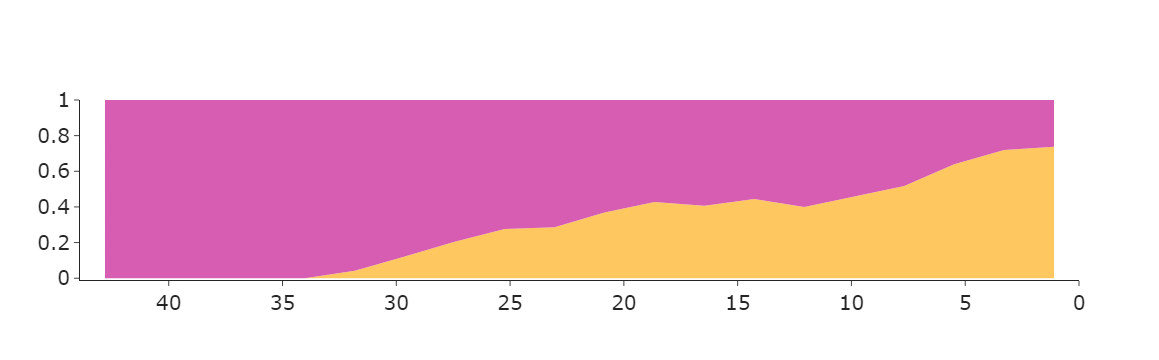

In [80]:
sub_df = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_predicted/summarized_prob.tsv',sep='\t',index_col=0)

col = 'dist'
hist_d = np.histogram(sub_df[col], bins=20, range = (0,max(sub_df[col])) )
xs = []
ys1 = []
ys2 = []
ys = []
left = 0
for right in hist_d[1]:
    #print(left,right)
    sdf = sub_df.loc[(sub_df[col]>=left) & (sub_df[col]<right),:]
    sdf = sdf.loc[[_ for _ in sdf.index if not _.startswith('G')],:]
    if sdf.shape[0]==0:continue
    num_anaerobe = len(sdf.index[sdf['A']<0.5])
    num_aerobe = sdf.shape[0]-num_anaerobe
    ys2.append(num_aerobe/sdf.shape[0])
    ys1.append(num_anaerobe/sdf.shape[0])
    ys.append(sdf.shape[0]/(sub_df.shape[0]-10575))
    xs.append(max(sub_df[col])-(left+right)/2)
    left = right
import plotly.graph_objects as go
fig = go.Figure()

fig.add_scatter(x=xs,y=ys2,mode='lines',opacity=0.7,fillcolor='#FFC75F', 
                marker=dict(size=4),
                name='Aerobe',fill='tozeroy',stackgroup='one',line=dict(width=0),showlegend=False)
fig.add_scatter(x=xs,y=ys1,mode='lines',opacity=0.7,fillcolor='#D65DB1',
                name='Anaerobe',fill='tonexty',stackgroup='one',line=dict(width=0),showlegend=False)
# fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
fig.update_layout(height=300,width=600,xaxis_range=[max(sub_df[col]),0],yaxis_zeroline=False,yaxis_range=[-0.01,1],
                  font_size=20,
                 template='simple_white')
fig.show()
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/sequential_dating/r45_withsishuo/ratio_distributions.pdf')

In [66]:
def inherit(n):
    if n =='OROOT':
        return 'Shifts'
    p = name2node[n]._up.name
    if p =='NoName':
        return 'Shifts'
    p1 = 'Aerobe' if sub_df.loc[n,'A'] <0.5 else 'Anaerobe'
    #print(p)
    p2 = 'Aerobe' if sub_df.loc[p,'A'] <0.5 else 'Anaerobe'
    if p1==p2:
        return 'inherit'
    else:
        return 'Shifts'

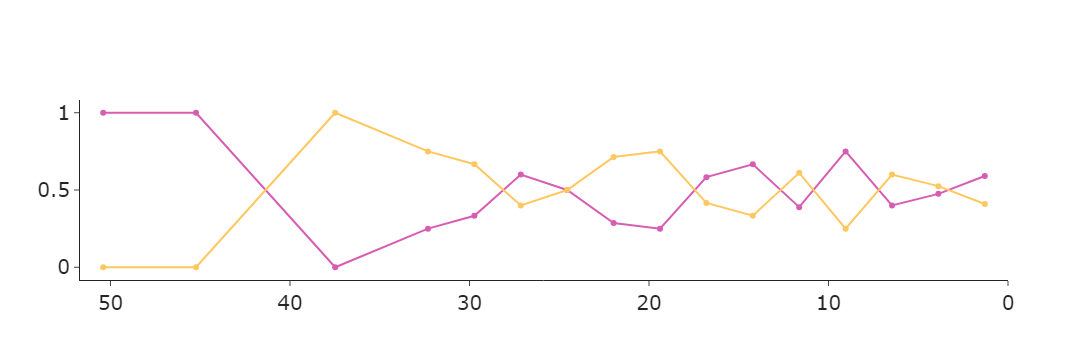

In [79]:
tre = Tree('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/sequential_dating/r45_withsishuo/root45_dated.nwk',format=3)
name2node = {_.name: _ for _ in tre.traverse()}

sub_df = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/LR_predicted/summarized_prob.tsv',sep='\t',index_col=0)

col = 'dist'
hist_d = np.histogram(sub_df[col], bins=20, range = (0,max(sub_df[col])) )
xs = []
ys1 = []
ys2 = []
ys = []
left = 0
for right in hist_d[1]:
    #print(left,right)
    sdf = sub_df.loc[(sub_df[col]>=left) & (sub_df[col]<right),:]
    sdf = sdf.loc[[_ for _ in sdf.index if not _.startswith('G')],:]
    
    remaining_nodes = []
    for n,row in sdf.iterrows():
        if inherit(n)=='Shifts':
            remaining_nodes.append(n)
    ssdf = sdf.loc[remaining_nodes,:]
    if ssdf.shape[0]==0:continue
    num_anaerobe = len(ssdf.index[ssdf['A']<0.5])
    num_aerobe = ssdf.shape[0]-num_anaerobe
    ys2.append(num_aerobe/ssdf.shape[0])
    ys1.append(num_anaerobe/ssdf.shape[0])
    #ys.append(sdf.shape[0]/(sub_df.shape[0]-10575))
    xs.append(max(sub_df[col])-(left+right)/2)
    left = right
#     if sdf.shape[0]>1:
#         break
import plotly.graph_objects as go
fig = go.Figure()
fig.add_scatter(x=xs,y=ys1,marker={'color':'#d65db1',},mode='markers+lines',name='Ratio of anaerobe from aerobes',showlegend=False,)
fig.add_scatter(x=xs,y=ys2,marker={'color':'#ffc75f',},mode='markers+lines',name='Ratio of aerobe from anaerobes',showlegend=False)
# fig.add_scatter(x=xs,y=ys2,mode='lines',opacity=0.7,fillcolor='#FFC75F', 
#                 marker=dict(size=4),
#                 name='Aerobe',fill='tozeroy',stackgroup='one',line=dict(width=0),showlegend=False)
# fig.add_scatter(x=xs,y=ys1,mode='lines',opacity=0.7,fillcolor='#D65DB1',
#                 name='Anaerobe',fill='tonexty',stackgroup='one',line=dict(width=0),showlegend=False)
# fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
fig.update_layout(height=300,width=800,xaxis_range=[max(sub_df[col]),0],yaxis_zeroline=False,
                  #yaxis_range=[-0.01,1],
                  font_size=20,
                 template='simple_white')
fig.show()        
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/sequential_dating/r45_withsishuo/turnover_ratios.pdf')

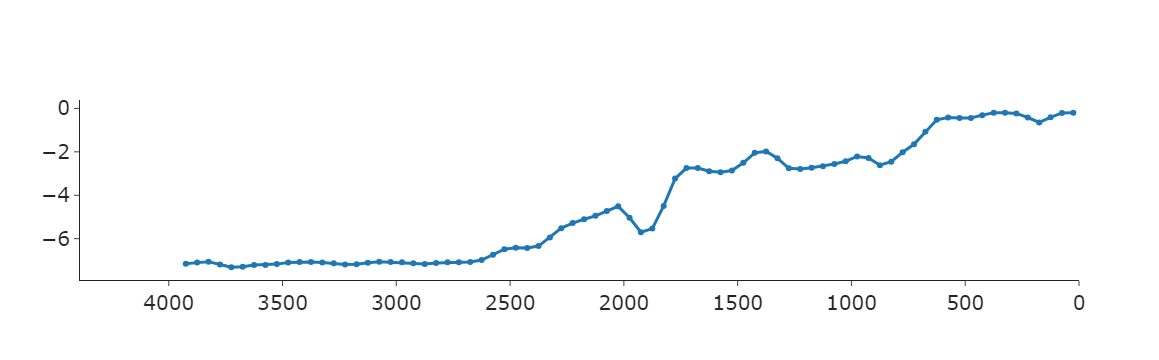

In [143]:
odf = pd.read_excel('./testing_sets/oxygen_records/Modeling_O2_SVR.xlsx')

fig = go.Figure()
fig.add_scatter(x=list(odf['Time']),
                y=list(odf['Non-filtered data']),
                mode='markers+lines',
                #opacity=0.7,
                #fillcolor='#FFC75F', 
                marker=dict(size=6),line=dict(width=3),showlegend=False)

fig.update_layout(height=300,width=600,xaxis_range=[max(sub_df[col])*100,0],yaxis_zeroline=False,#yaxis_range=[-0.01,1],
                  font_size=20,
                 template='simple_white')
fig.show()
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/oxygen_records/oxygen_changes.pdf')
#fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/sequential_dating/r45_withsishuo/ratio_distributions.pdf')

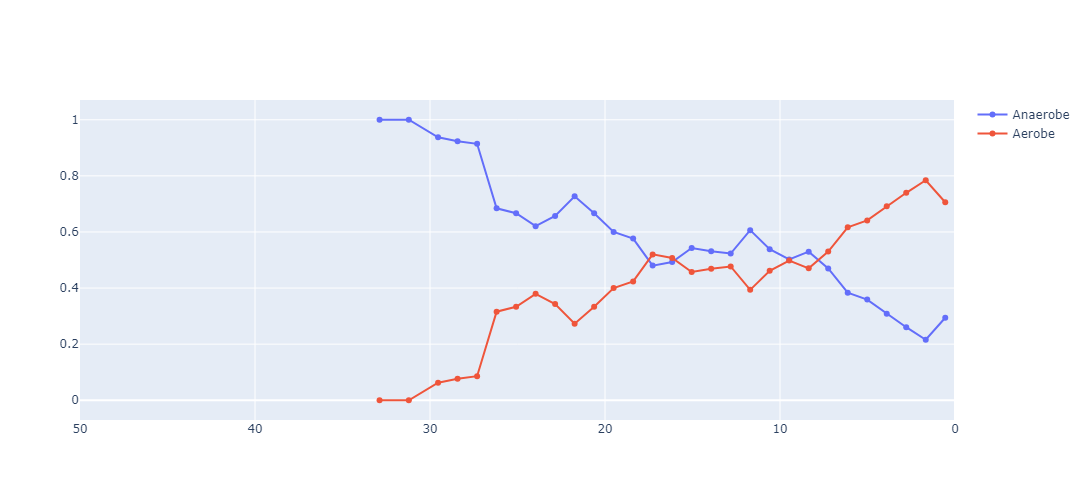

In [25]:
col = 'dist'
hist_d = np.histogram(sub_df[col], bins=30, range = (0,max(sub_df['dist'])) )
xs = []
ys1 = []
ys2 = []
ys = []
left = 0
for right in hist_d[1]:
    #print(left,right)
    sdf = sub_df.loc[(sub_df[col]>=left) & (sub_df[col]<right),:]
    sdf = sdf.loc[[_ for _ in sdf.index if not _.startswith('G')],:]
    if sdf.shape[0]==0:continue
    num_anaerobe = len(sdf.index[sdf['A']<0.5])
    num_aerobe = sdf.shape[0]-num_anaerobe
    ys2.append(num_aerobe/sdf.shape[0])
    ys1.append(num_anaerobe/sdf.shape[0])
    ys.append(sdf.shape[0]/(sub_df.shape[0]-10575))
    xs.append(max(sub_df[col])-(left+right)/2)
    left = right
import plotly.graph_objects as go
fig = go.Figure()
fig.add_scatter(x=xs,y=ys1,mode='markers+lines',name='Anaerobe')
fig.add_scatter(x=xs,y=ys2,mode='markers+lines',name='Aerobe')
# fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
fig.layout.width = 500
fig.layout.height = 500
fig.layout.xaxis.range = [50,0]
fig.show()

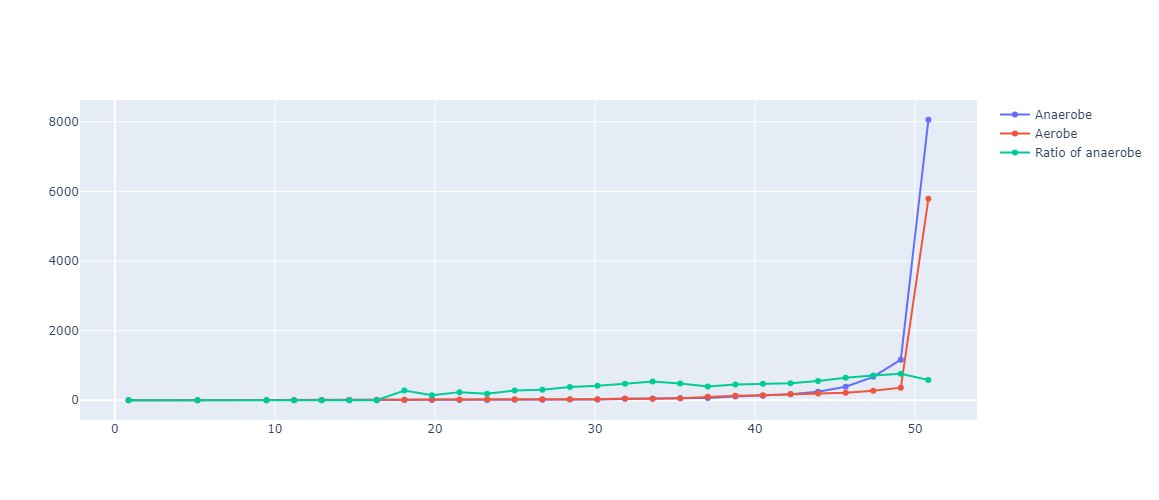

In [27]:
hist_d = np.histogram(sub_df['dist'], bins=30, range = (0,max(sub_df['dist'])) )
xs = []
ys1 = []
ys2 = []
ys = []
left = 0
for right in hist_d[1]:
    sdf = sub_df.loc[(sub_df['dist']>=left) & (sub_df['dist']<right),:]
    if sdf.shape[0]==0:continue
    num_anaerobe = len(sdf.index[sdf['A']>=0.5])
    num_aerobe = sdf.shape[0]-num_anaerobe
    ys2.append(num_aerobe)
    ys1.append(num_anaerobe)
    ys.append(num_anaerobe/(sdf.shape[0])*1000 )
    xs.append((left+right)/2)
    left = right
import plotly.graph_objects as go
fig = go.Figure()
fig.add_scatter(x=xs,y=ys1,mode='markers+lines',name='Anaerobe')
fig.add_scatter(x=xs,y=ys2,mode='markers+lines',name='Aerobe')
fig.add_scatter(x=xs,y=ys,mode='markers+lines',name='Ratio of anaerobe')
fig.layout.width = 500
fig.layout.height = 500
fig.show()

### gtdb

In [196]:
tre = Tree("/mnt/storage3/thliao/project/ML_oxygen/testing_sets/GTDB_r214/sequential_dating/root45_dated.nwk",1)
tre

Tree node '' (0x7f96e4d74c5)

In [197]:
ns = len([n for n in tre.traverse() if not n.is_leaf()])
ns

80786

---

## gene tree annotations

In [241]:
from api_tools import *

gene = 'K04069'
_t = Tree(f'/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/annofaa/{gene}.newick').get_leaf_names()
g = {_:_.split('_')[0] for _ in _t}
g2a = wol_ances_predicted['LR'].to_dict()
g2t = {gene: 'Aerobe' if g2a[genome]==1 else 'Anaerobe' for gene,genome in g.items()}
text = to_color_strip(g2t,{"Aerobe":"#FFC75F","Anaerobe":"#D65DB1"},other_params={"margin":"50","strip_width":"50"},
                     dataset_name='oxygen requirement')
with open(f"/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/annofaa/{gene}.colorstrip.txt","w") as f1:
    f1.write(text)

wol_g2tax = {_.split(',')[0]:_.split(',')[2] for _ in open('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/tax_colorstrip.txt').read().split('\n') if len(_.split(','))==3 and _.startswith('G')}
wol_tax2c = {_.split(',')[2]:_.split(',')[1] for _ in open('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/tax_colorstrip.txt').read().split('\n') if len(_.split(','))==3 and _.startswith('G')}

g2t = {gene: wol_g2tax[genome] for gene,genome in g.items()}

text = to_color_strip(g2t,{k:v for k,v in wol_tax2c.items() if k in g2t.values()} ,
                      dataset_name='Major lineages',
                      other_params={"margin":"50","strip_width":"50"})
with open(f"/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/annofaa/{gene}.tax_colorstrip.txt","w") as f1:
    f1.write(text)

## compare the top 50 gene topology

In [112]:
from ete3 import Tree
from glob import glob
import itertools
top50 = open('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/top50.txt').read().strip().split('\n')

In [151]:
def update_gname(tre):
    for n in tre.get_leaves():
        n.add_feature('gname',n.name.split('_')[0])
    return tre

import copy
def random_prune_duplicated(tre1):
    tre = copy.deepcopy(tre1)
    k2ori = defaultdict(list)
    for k in tre.get_leaf_names():
        k2ori[k.split('_')[0]].append(k)
    #k2final_n = {}
    tre.prune([_[0] for _ in k2ori.values()])
    return tre


In [206]:
top50_summary = pd.read_excel('/mnt/ivy/thliao/project/ML_oxygen/training_sets/Selected50/top50_summary.xlsx',index_col=0)


In [213]:
anaerobe_genes = top50_summary.index[top50_summary['ratio of presences in aerobe/anaerobe']<1]
aerobe_genes = top50_summary.index[top50_summary['ratio of presences in aerobe/anaerobe']>=1]

In [ ]:
rf_dis = {}
for g1,g2 in tqdm(itertools.combinations(top50,r=2)):
    t1,t2 = [f"/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/annofaa/{_}.newick" for _ in [g1,g2]]
    if exists(t1) and exists(t2):
        tre1=Tree(t1)
        tre2=Tree(t2)
        tre1 = update_gname(tre1)
        tre2 = update_gname(tre2)
        rantre1 = random_prune_duplicated(tre1)
        rantre2 = random_prune_duplicated(tre2)
        compare_info = rantre1.compare(rantre2,unrooted=True,ref_tree_attr='gname',source_tree_attr='gname')
        rf_dis[(g1,g2)] = (compare_info['rf'],compare_info['max_rf'],compare_info['norm_rf'])

126it [1:06:42, 47.07s/it]

In [197]:
stre = Tree("/mnt/home-backup/thliao/wol_db/data/trees/astral/branch_length/cons/astral.cons.nid.nwk",1)
rf_dis2ref = {}
for g in tqdm(top50):
    t = f"/mnt/ivy/thliao/project/ML_oxygen/testing_sets/WoL/annofaa/{g}.newick"
    if exists(t):
        tre1=Tree(t)
        tre1 = update_gname(tre1)
        rantre1 = random_prune_duplicated(tre1)
        compare_info = rantre1.compare(stre,unrooted=True,ref_tree_attr='name',source_tree_attr='gname')
        rf_dis2ref[g] = (compare_info['rf'],compare_info['max_rf'],compare_info['norm_rf'])
        print((compare_info['rf'],compare_info['max_rf'],compare_info['norm_rf']))

  2%|▏         | 1/50 [02:41<2:11:40, 161.23s/it]

(7177.0, 10261.0, 0.6994444985868824)


  4%|▍         | 2/50 [04:05<1:50:36, 138.25s/it]

(2211.0, 3005.0, 0.7357737104825292)


  6%|▌         | 3/50 [06:27<1:49:03, 139.23s/it]

(5637.0, 8953.0, 0.6296213559700659)


  8%|▊         | 4/50 [08:35<1:44:06, 135.79s/it]

(5787.0, 7825.0, 0.7395527156549521)


 10%|█         | 5/50 [10:37<1:38:53, 131.84s/it]

(4996.0, 7198.0, 0.6940816893581551)


 12%|█▏        | 6/50 [11:59<1:25:43, 116.90s/it]

(1252.0, 2194.0, 0.5706472196900638)


 14%|█▍        | 7/50 [14:16<1:28:02, 122.85s/it]

(3754.0, 8678.0, 0.43258815395252365)


 16%|█▌        | 8/50 [17:03<1:35:17, 136.14s/it]

(6444.0, 10612.0, 0.6072370900866944)


 18%|█▊        | 9/50 [18:43<1:25:39, 125.35s/it]

(3710.0, 5062.0, 0.7329118925325958)


 20%|██        | 10/50 [20:41<1:22:05, 123.13s/it]

(5489.0, 6193.0, 0.8863232682060391)


 22%|██▏       | 11/50 [23:19<1:26:51, 133.62s/it]

(6240.0, 10088.0, 0.6185567010309279)


 24%|██▍       | 12/50 [25:43<1:26:25, 136.47s/it]

(7195.0, 8737.0, 0.8235092136889093)


 26%|██▌       | 13/50 [28:03<1:24:57, 137.76s/it]

(4869.0, 8783.0, 0.5543663896163042)


 28%|██▊       | 14/50 [30:01<1:19:03, 131.76s/it]

(4072.0, 6628.0, 0.6143633071816536)


 30%|███       | 15/50 [31:51<1:13:06, 125.33s/it]

(3534.0, 5878.0, 0.6012249064307588)


 32%|███▏      | 16/50 [33:27<1:05:57, 116.39s/it]

(2455.0, 4381.0, 0.560374343757133)


 34%|███▍      | 17/50 [35:07<1:01:18, 111.46s/it]

(3107.0, 4989.0, 0.6227700942072559)


 36%|███▌      | 18/50 [37:09<1:01:10, 114.69s/it]

(4470.0, 7120.0, 0.6278089887640449)


 38%|███▊      | 19/50 [39:52<1:06:43, 129.13s/it]

(6783.0, 10261.0, 0.6610466816099795)


 40%|████      | 20/50 [41:16<57:49, 115.66s/it]  

(1708.0, 2914.0, 0.5861358956760466)


 42%|████▏     | 21/50 [42:49<52:37, 108.87s/it]

(3000.0, 4496.0, 0.6672597864768683)


 44%|████▍     | 22/50 [44:13<47:17, 101.33s/it]

(2252.0, 3248.0, 0.6933497536945813)


 46%|████▌     | 23/50 [46:46<52:36, 116.90s/it]

(6212.0, 9974.0, 0.6228193302586725)


 48%|████▊     | 24/50 [48:12<46:35, 107.51s/it]

(2123.0, 3203.0, 0.6628161098969716)


 50%|█████     | 25/50 [50:09<46:02, 110.50s/it]

(5759.0, 6891.0, 0.8357277608474822)


 52%|█████▏    | 26/50 [51:58<44:01, 110.04s/it]

(3654.0, 6154.0, 0.5937601559961001)


 54%|█████▍    | 27/50 [54:13<44:59, 117.36s/it]

(5376.0, 8464.0, 0.6351606805293005)


 56%|█████▌    | 28/50 [56:07<42:39, 116.33s/it]

(5279.0, 6017.0, 0.8773475153731095)


 58%|█████▊    | 29/50 [57:58<40:14, 114.96s/it]

(4286.0, 6334.0, 0.6766656141458793)


 60%|██████    | 30/50 [1:00:46<43:34, 130.74s/it]

(6398.0, 11054.0, 0.5787950063325493)


 62%|██████▏   | 31/50 [1:03:10<42:39, 134.70s/it]

(7220.0, 9096.0, 0.7937554969217239)


 64%|██████▍   | 32/50 [1:05:10<39:07, 130.43s/it]

(4298.0, 7060.0, 0.6087818696883853)


 66%|██████▌   | 33/50 [1:07:07<35:47, 126.34s/it]

(4955.0, 5259.0, 0.9421943335234836)


 68%|██████▊   | 34/50 [1:08:29<30:09, 113.10s/it]

(1313.0, 2135.0, 0.6149882903981264)


 70%|███████   | 35/50 [1:09:59<26:32, 106.14s/it]

(2798.0, 3922.0, 0.7134115247322794)


 72%|███████▏  | 36/50 [1:12:38<28:28, 122.04s/it]

(6825.0, 10221.0, 0.6677428823011446)


 74%|███████▍  | 37/50 [1:15:25<29:21, 135.53s/it]

(6490.0, 10756.0, 0.6033841576794348)


 76%|███████▌  | 38/50 [1:17:23<26:03, 130.32s/it]

(5172.0, 5500.0, 0.9403636363636364)


 80%|████████  | 40/50 [1:18:51<17:23, 104.35s/it]

(2250.0, 3356.0, 0.6704410011918951)


 82%|████████▏ | 41/50 [1:21:06<17:01, 113.55s/it]

(6748.0, 8266.0, 0.8163561577546576)


 84%|████████▍ | 42/50 [1:23:20<15:57, 119.65s/it]

(6517.0, 7985.0, 0.8161552911709455)


 86%|████████▌ | 43/50 [1:25:28<14:15, 122.20s/it]

(4152.0, 7728.0, 0.5372670807453416)


 88%|████████▊ | 44/50 [1:27:04<11:25, 114.33s/it]

(2293.0, 4453.0, 0.5149337525263867)


 90%|█████████ | 45/50 [1:28:43<09:08, 109.66s/it]

(2750.0, 4796.0, 0.573394495412844)


 92%|█████████▏| 46/50 [1:30:40<07:28, 112.03s/it]

(3977.0, 6689.0, 0.5945582299297354)


 94%|█████████▍| 47/50 [1:33:06<06:06, 122.14s/it]

(5611.0, 9299.0, 0.6033982148618131)


 96%|█████████▌| 48/50 [1:35:19<04:10, 125.39s/it]

(5962.0, 8036.0, 0.7419113987058238)


 98%|█████████▊| 49/50 [1:37:52<02:13, 133.78s/it]

(6254.0, 9804.0, 0.6379028967768258)


100%|██████████| 50/50 [1:40:22<00:00, 120.46s/it]

(5967.0, 9435.0, 0.6324324324324324)


### RF distance histogram (separate genes)

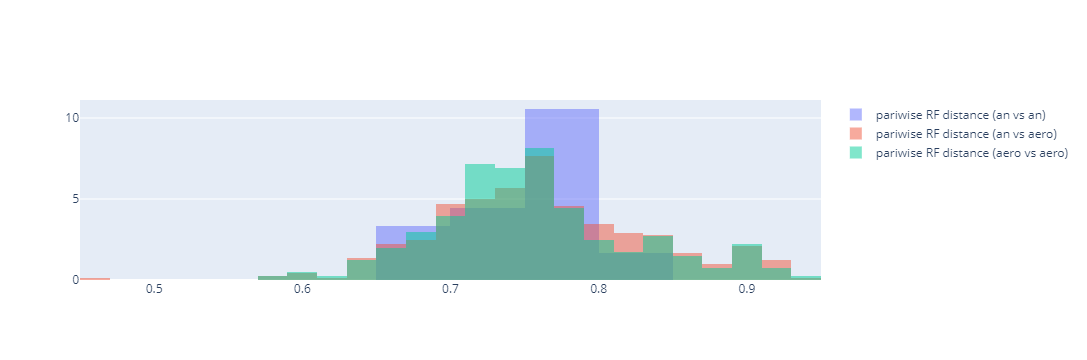

In [215]:
fig = go.Figure()
fig.add_histogram(x=[v[2] for k,v in rf_dis.items() if k[0] in anaerobe_genes and k[1] in anaerobe_genes ],histnorm='probability density',name='pariwise RF distance (an vs an)',opacity=0.5)
fig.add_histogram(x=[v[2] for k,v in rf_dis.items() if (k[0] in anaerobe_genes and k[1] in aerobe_genes) or (k[1] in anaerobe_genes and k[0] in aerobe_genes) ],histnorm='probability density',name='pariwise RF distance (an vs aero)',opacity=0.5)
fig.add_histogram(x=[v[2] for k,v in rf_dis.items() if k[0] in aerobe_genes and k[1] in anaerobe_genes ],histnorm='probability density',name='pariwise RF distance (aero vs aero)',opacity=0.5)
fig.update_layout(barmode='overlay')
fig.show()

### RF distance histogram (gene and species)

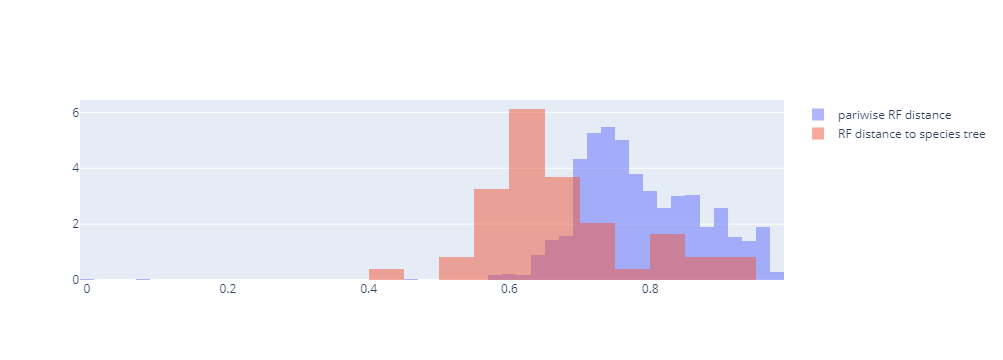

In [202]:
fig = go.Figure()
fig.add_histogram(x=[_[2] for _ in rf_dis.values()],histnorm='probability density',name='pariwise RF distance',opacity=0.5)
fig.add_histogram(x=[_[2] for _ in rf_dis2ref.values()],histnorm='probability density',name='RF distance to species tree',opacity=0.5)
fig.update_layout(barmode='overlay')
fig.show()

# output tree

In [52]:
from api_tools import *

import ete3
meta_df = pd.read_csv('/mnt/ivy/thliao/data/gtdb/bac120_metadata_r207.tsv',sep='\t',index_col=0)
id2genbank_id = meta_df['ncbi_genbank_assembly_accession'].to_dict()

bac_tree = ete3.PhyloTree(
    "/mnt/ivy/thliao/data/gtdb/bac120_r207.tree",
    format=1,
    quoted_node_names=True,
)
phy2sub_tree = {n.name.split(':')[-1].split(';')[0]: n
                for n in bac_tree.traverse() 
                if 'p__' in n.name}
phy2des_node_list = {n.name.split(':')[-1].split(';')[0]: [id2genbank_id[_] for _ in list(n.get_leaf_names()) ]
                 for n in bac_tree.traverse() if 'p__' in n.name}
color_map = {'Aerobe': "#F9F871", 
             'Anaerobe': "#845EC2" }

In [49]:
meta_df.loc['GB_GCA_016235825.1',:].to_dict()

In [45]:
id2tax_fullname = {id2genbank_id[k]:v for k,v in meta_df['gtdb_taxonomy'].to_dict().items()}
text = to_label({k:v for k,v in id2tax_fullname.items() if k in planto_kegg_bindf.index})
with open("./testing_sets/plancto_fulltaxname.txt", "w") as f1:
    f1.write(text)
text = to_label({k:v for k,v in id2tax_fullname.items() if k in verruco_kegg_bindf.index})
with open("./testing_sets/verruco_fulltaxname.txt", "w") as f1:
    f1.write(text)

In [54]:
tre = phy2sub_tree['p__Planctomycetota'].copy()
for l in tre.get_leaves():
    l.name = id2genbank_id[l.name]
tre.prune(planto_kegg_bindf.index)
tre.write(outfile='./testing_sets/planto_tree.newick')

l = ['Aerobe' if _ >=0.5 else 'Anaerobe' for _ in planto_predict_y]
text = to_color_range(
    dict(zip(planto_kegg_bindf.index,
             l)),
    info2color=color_map,
)
with open("./testing_sets/plancto_predict.txt", "w") as f1:
    f1.write(text)

text = color_gradient(
    {gid:prob*100 for gid,prob in dict(zip(planto_kegg_bindf.index,planto_predict_y)).items()},
    mid_val=None,
    dataset_name='prediction probility',
    other_params={'margin':50,
                 'strip_width':50},
)  
with open("./testing_sets/plancto_predict_prob.txt", "w") as f1:
    f1.write(text)


In [50]:
name = 'verruco'
tre = phy2sub_tree['p__Verrucomicrobiota'].copy()
for l in tre.get_leaves():
    l.name = id2genbank_id.get(l.name,l.name)
tre.copy().prune(verruco_kegg_bindf.index)
tre.write(outfile=f'./testing_sets/{name}_tree.newick')

l = ['Aerobe' if _ >=0.5 else 'Anaerobe' for _ in verruco_predict_y]
text = to_color_range(
    dict(zip(verruco_kegg_bindf.index,
             l)),
    info2color=color_map,
)
with open(f"./testing_sets/{name}_predict.txt", "w") as f1:
    f1.write(text)

text = color_gradient(
    {gid:prob*100 for gid,prob in dict(zip(verruco_kegg_bindf.index,
                                           verruco_predict_y)).items()},
    mid_val=None,
    dataset_name='prediction probility',
        other_params={'margin':50,
                 'strip_width':50},
)  
with open(f"./testing_sets/{name}_predict_prob.txt", "w") as f1:
    f1.write(text)

In [ ]:
## selected fea to predict

In [ ]:
ko2coef = {}
for ko in top40:
    x = reduced_data.loc[:,ko]
    y = y_bin
    coef,p = pearsonr(x,y)
    ko2coef[ko] = coef
with open('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/top40_pear.txt','w') as f1:
    for ko,coef in ko2coef.items():
        f1.write(f"{ko}\t{coef}\n")

ko_aero = [k for k,v in ko2coef.items() if v >0]
ko_anaero = [k for k,v in ko2coef.items() if v <0]

In [70]:
model = GBDT_m( reduced_data.loc[:,top40], y_bin, )

In [ ]:
target_dir = "/mnt/ivy/thliao/project/ML_oxygen/testing_sets/top120_annotations"
suffix = '.hmmout'
anno_file = f"{target_dir}/kegg_anno.tab"
final_df = pd.read_csv(anno_file, sep='\t', index_col=0)

preds = model.predict(xgb.DMatrix(bin_df))

shap_vals = model.predict(xgb.DMatrix(bin_df), pred_contribs=True)
shap_vals = shap_vals[:, :-1]  # the last column is the bias term, needed to be removed
shap_df = pd.DataFrame(shap_vals,index=bin_df.index,columns=top40)
shap_df

In [98]:
def get_highest_f(row):
    total = row.abs().sum()
    ko1_max = ko_aero[int(row[ko_aero].abs().argmax())]
    ko2_max = ko_anaero[int(row[ko_anaero].abs().max())]
    k1_r = abs(row[ko1_max])/total*100
    k2_r = abs(row[ko2_max])/total*100
    return (ko1_max,k1_r,ko2_max,k2_r)

In [99]:
shap_df.iloc[:2,:].apply(get_highest_f,axis=1)

GCA_013360915.1    (K08973, 9.480136632919312, K04069, 2.29573212...
GCA_017303995.1    (K02257, 27.76012122631073, K20203, 0.04627704...
dtype: object

In [100]:
with open('/mnt/ivy/thliao/project/ML_oxygen/testing_sets/15200_gids_prediction.tsv','w') as f1:
    for g,p in zip(bin_df.index,preds):
        n = 'aerobe' if p >0.5 else 'anaerobe'
        f1.write(f"{g}\t{p}\t{n}\n")